In [1]:
import scipy
import numpy as np
import json
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import os
from scipy.signal import convolve
from analysis_pkg.tools.util import normalize
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pickle
from analysis_pkg.calciumImaging.tools import select_RPEneurons_GLM

In [2]:
def load_bpod_data(dpath):
    with open(dpath, 'r') as file:
        data = json.load(file)
    return data

def take_closest(ms_stamps, bpod_stamps):
    """
    Assumes ms_stamps is sorted. Returns closest stamps to the given bpod_stamps.

    If two numbers are equally close, return the smallest number.
    """
    msAlignedIndex = []
    for bpod_stamp in bpod_stamps:
        pos = bisect_left(ms_stamps, bpod_stamp)
        if pos == 0:
            return ms_stamps[0]
        if pos == len(ms_stamps):
            return ms_stamps[-1]
        before = ms_stamps[pos - 1]
        after = ms_stamps[pos]
        if after - bpod_stamp < bpod_stamp - before:
            msAlignedIndex.append(np.where(ms_stamps ==after))
        else:
            msAlignedIndex.append(np.where(ms_stamps ==before))
    return np.squeeze(np.array(msAlignedIndex))
    
def get_state_time(state, bpod_data, trialnumbers=None):
    """
    Input a state name and bpod_data. Return the time stamp of the state(relative to trial start)
    """
    onsets = []

    if trialnumbers is not None:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            if type(trial['States'][state][0]) != float:
                onsets.append(trial['States'][state][0][0])
            else:
                onsets.append(trial['States'][state][0])
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            if type(trial['States'][state][0]) != float:
                onsets.append(trial['States'][state][0][0])
            else:
                onsets.append(trial['States'][state][0])
            # onsets.append(np.squeeze(trial['States'][state])[0])
    return np.array(onsets)
    
def get_RPE_neuron_activities(trialRewards, calcium_activities, calcium_baselines=None):
    """Select RPE relative neurons using the method from Muller. 2024 """
    if not calcium_baselines:
        calcium_baselines = np.zeros(calcium_activities.shape)
    RPE_neurons = []
    RPE_neurons_id = []
    for i, singleNeuronActivity in enumerate(calcium_activities):
        trialRewards_constant = sm.add_constant(trialRewards)
        model = sm.OLS(singleNeuronActivity, trialRewards_constant).fit()
        if model.pvalues[1] < 0.05:
            # print(singleNeuronActivity)
            # print(calcium_baselines[i])
            # print(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons.append(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons), np.array(RPE_neurons_id)

def z_score(data, axis=1):
    return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)

def mean_across_events(events, raw_neural_activities, fps=30, duration=2):  
    sum_acitivities = np.zeros((raw_neural_activities.shape[0],fps*duration*2))
    for event in events:
        raw_neural_activities_cue_onset = np.array(raw_neural_activities[:, event-duration*fps:event+duration*fps])
        sum_acitivities = raw_neural_activities_cue_onset + sum_acitivities
    return sum_acitivities/len(events)

def create_raised_cosine_basis(n_basis, window_length_frames, dt=1):
    """
    Create a set of raised cosine basis functions over a specified window (in frames).

    Parameters:
      n_basis             : int
          Number of basis functions.
      window_length_frames: int or float
          Duration (in frames) over which to define the basis functions.
      dt                  : int or float, optional
          Time resolution. For frame-based data, dt=1 (one frame per step).

    Returns:
      t         : 1D numpy array
          The frame vector spanning the window.
      basis_set : 2D numpy array of shape (n_basis, len(t))
          Each row corresponds to one raised cosine basis function.
    """
    # Create a vector of frame indices over the window.
    t = np.arange(0, window_length_frames, dt)
    
    # Determine centers for each basis function, evenly spaced over the window.
    centers = np.linspace(0, window_length_frames, n_basis)
    
    # Choose a width for the basis functions.
    # The width controls how broad each function is. You can adjust the scaling factor as needed.
    width = (window_length_frames / (n_basis - 1)) * 1.5  # 1.5 is an adjustable scaling factor.
    
    basis_set = []
    for center in centers:
        # Compute the argument for the cosine, then clip it so that it only has nonzero values over a finite interval.
        cosine_arg = np.clip((t - center) * np.pi / width, -np.pi, np.pi)
        basis = (np.cos(cosine_arg) + 1) / 2  # Scale to range [0,1]
        
        # Optionally zero out values outside a window centered on the current basis function.
        basis[t < (center - width/2)] = 0
        basis[t > (center + width/2)] = 0
        
        basis_set.append(basis)
    
    return t, np.array(basis_set)

def poisson_deviance(y, mu):
    """
    Compute the deviance for Poisson data.
    
    Parameters:
      y  : array of observed counts
      mu : array of predicted counts (should be > 0)
      
    Returns:
      The deviance value.
    """
    # Use np.where to avoid computing log(0); when y==0, treat y*log(y/mu) as 0.
    term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
    return 2 * np.sum(term)

def find_all_zero_crossings(x, y):
    zero_crossings = []

    for i in range(1, len(y)):
        if y[i-1] < 0 and y[i] > 0:
            # Linear interpolation to find the x where y crosses 0
            x0, y0 = x[i-1], y[i-1]
            x1, y1 = x[i], y[i]
            zero_x = x0 - y0 * (x1 - x0) / (y1 - y0)
            zero_crossings.append(zero_x)

    return zero_crossings

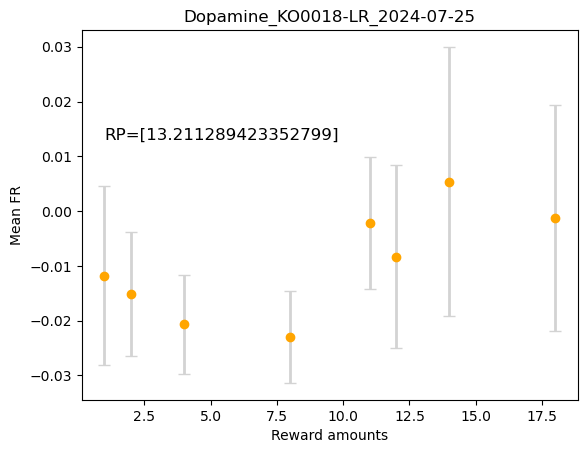

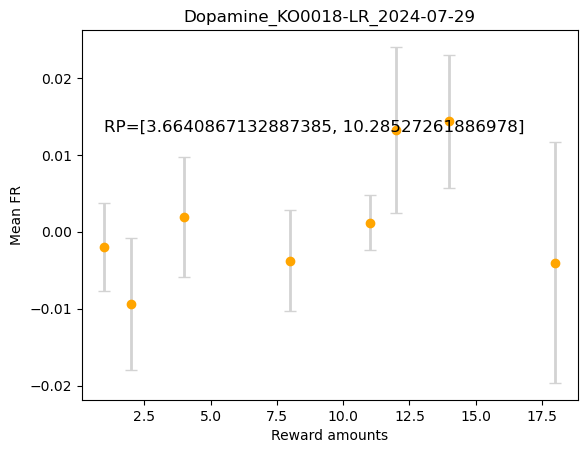

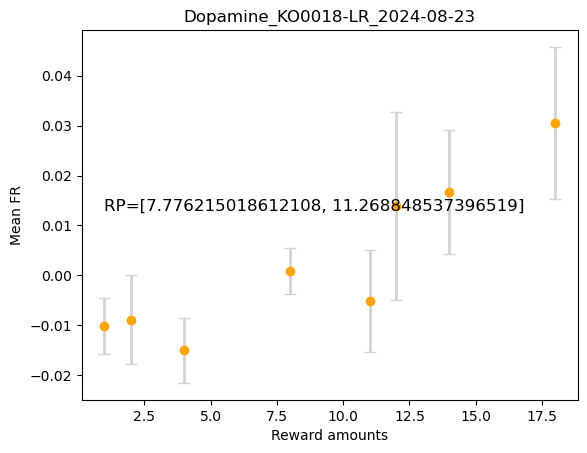

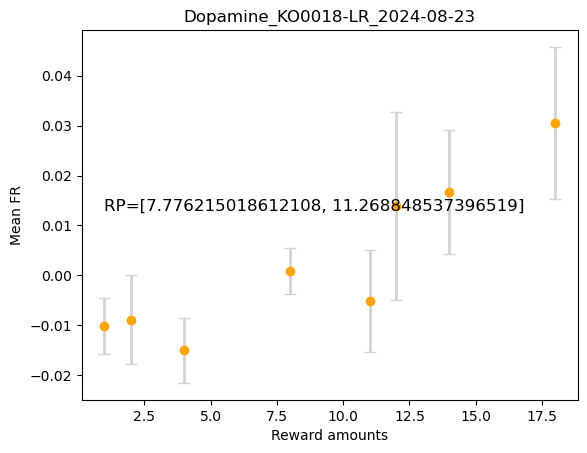

In [ ]:
# for date in ['2024-07-25','2024-07-29','2024-08-23','2024-08-23']:
#     mouse = 'KO0018-LR'
#     date = date
#     date_in_bpod = date.replace("-", "")

#     ### load bpod results
#     bpod_data = load_bpod_data(glob.glob(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse}/*{mouse}*{date_in_bpod}*')[0])
#     trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])


#     with open(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/dopamine_data/{mouse}_{date}_pyp_akam.pkl', 'rb') as f:
#         dopamine_data = pickle.load(f)


#     FS = 130

#     zscored_dopamine_signal = dopamine_data['pyp_zscored']
#     dff_dopamine_signal = dopamine_data['pyp_dff0']
#     rewardTimes = get_state_time('Drinking', bpod_data)
#     rewardStamps = np.rint(dopamine_data['pyp_pulse_inds'] + rewardTimes*FS).astype(int)

#     reward_binary = np.zeros((zscored_dopamine_signal.shape[0],1))
#     for i, frame in enumerate(rewardStamps):
#         reward_binary[frame] = trialRewards[i]

#     mean_baseline_activities = []
#     for rewardStamp in rewardStamps:
#         mean_baseline_activity = dff_dopamine_signal[rewardStamp-65:rewardStamp].mean(axis=0)
#         mean_baseline_activities.append(mean_baseline_activity)
#     mean_baseline_activities = np.array(mean_baseline_activities)

#     mean_reward_activities = []
#     for rewardStamp in rewardStamps:
#         mean_reward_activity = dff_dopamine_signal[rewardStamp:rewardStamp+130].mean(axis=0)
#         mean_reward_activities.append(mean_reward_activity)
#     mean_reward_activities = np.array(mean_reward_activities) - mean_baseline_activities

#     reward_amounts = [1,2,4,8,11,12,14,18]
#     means = []
#     for reward_amount in reward_amounts:
#         mean = np.mean(mean_reward_activities[trialRewards == reward_amount])
#         means.append(mean)
#         std = np.std(mean_reward_activities[trialRewards == reward_amount])
#         #plt.scatter(reward_amount, mean, color='orange', s=50)
#         plt.errorbar(reward_amount, mean, yerr=std, fmt='o', color='orange', ecolor='lightgray', elinewidth=2, capsize=4)
#     reversal_point = find_all_zero_crossings(np.array(reward_amounts), np.array(means))
#     plt.text(1, 0.013,f'RP={reversal_point}', fontsize=12, color='black')
#     plt.xlabel('Reward amounts')
#     plt.ylabel('Mean FR')
#     plt.title(f'Dopamine_{mouse}_{date}')
#     plt.show()

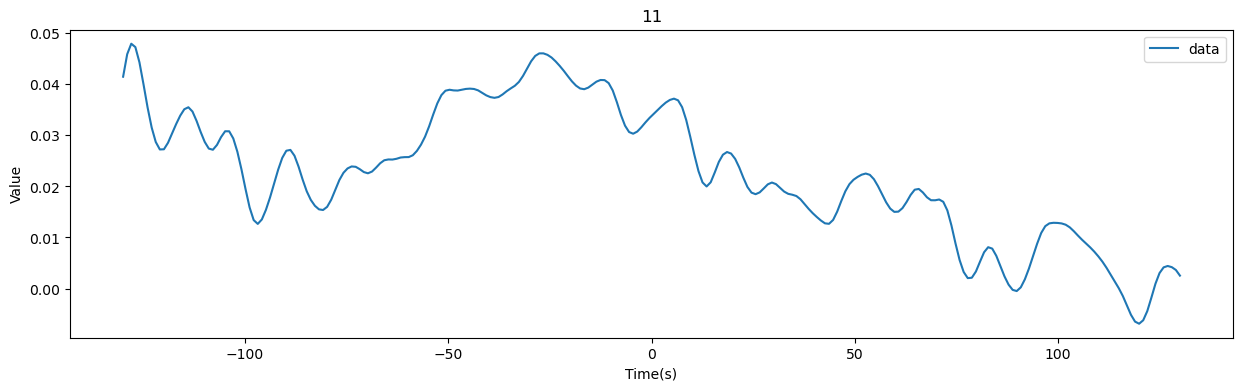

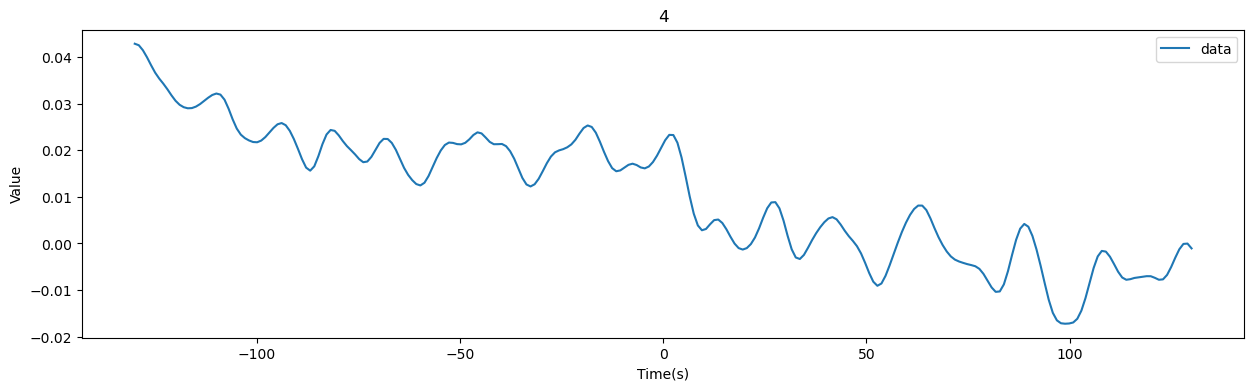

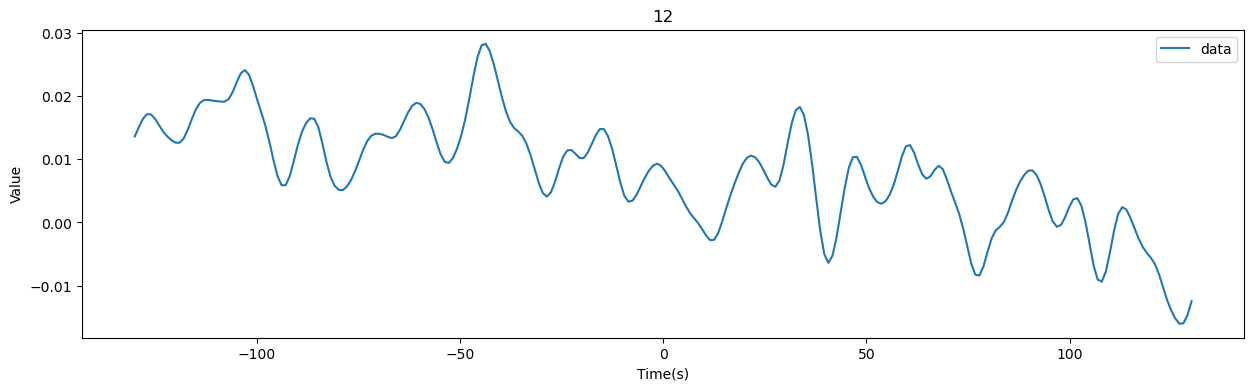

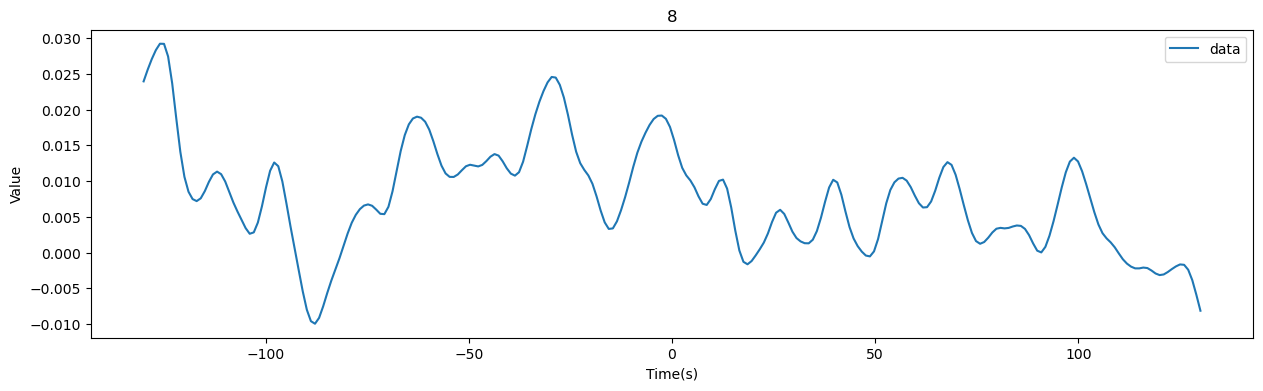

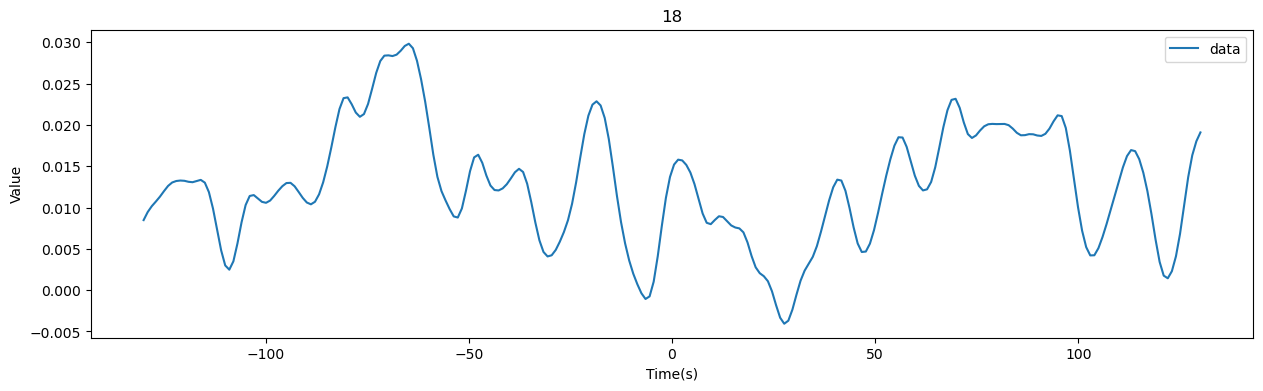

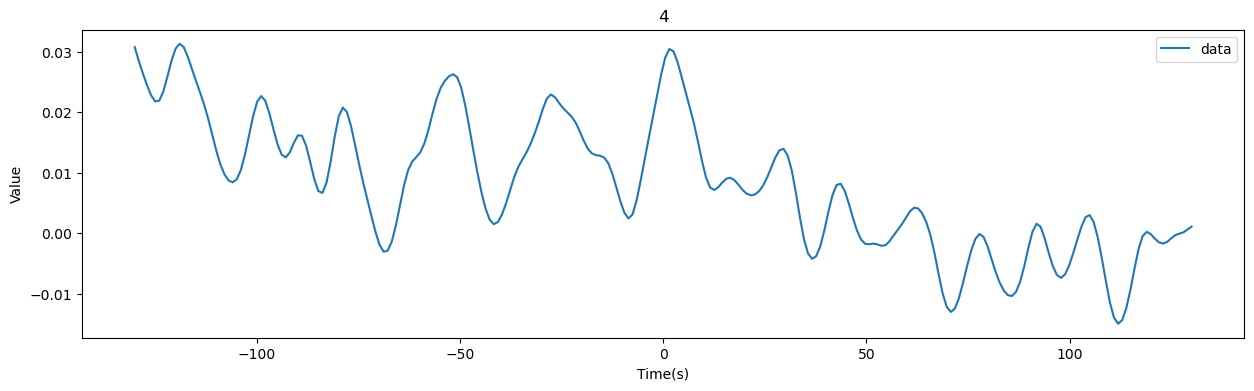

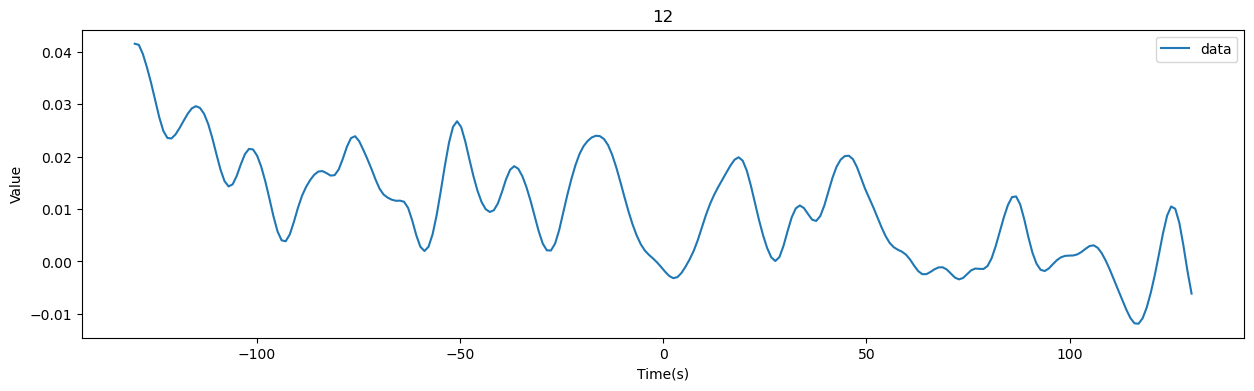

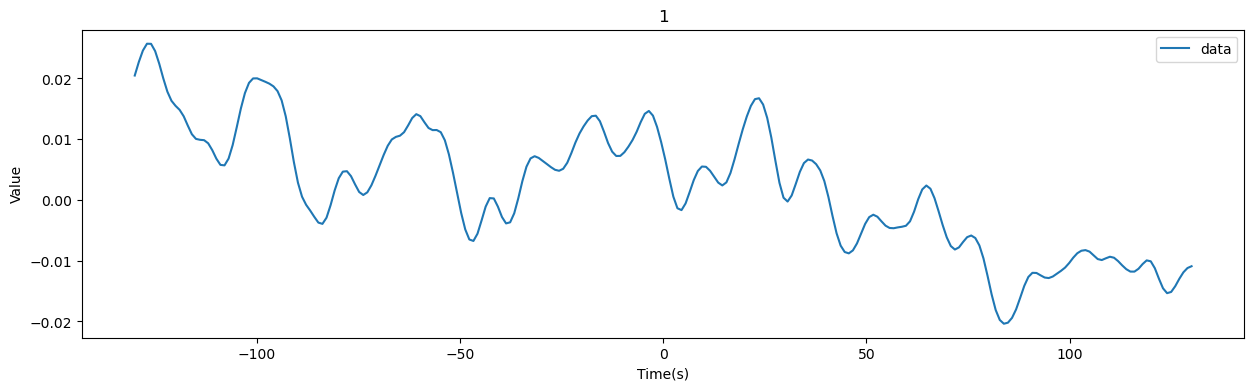

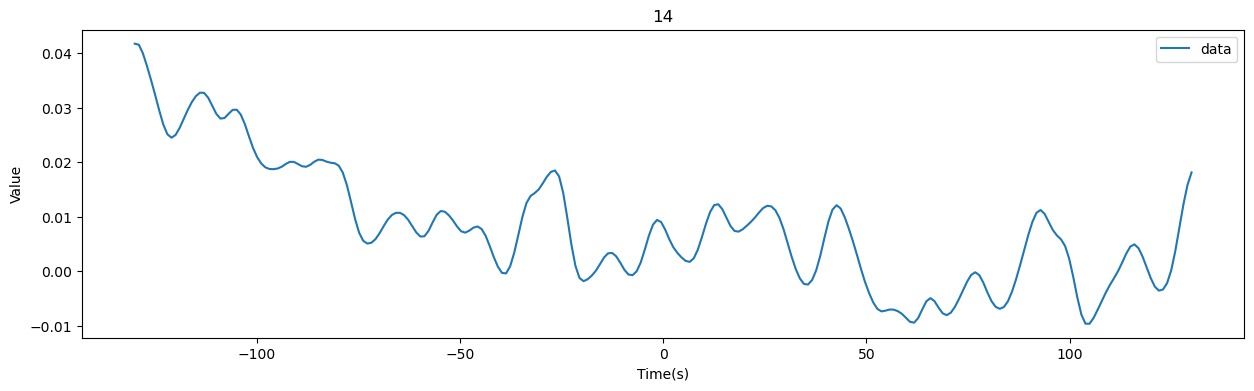

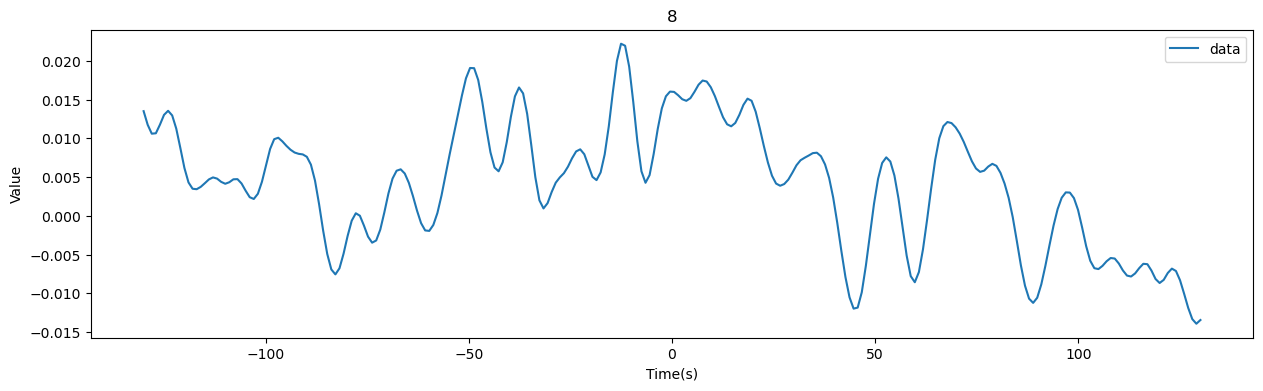

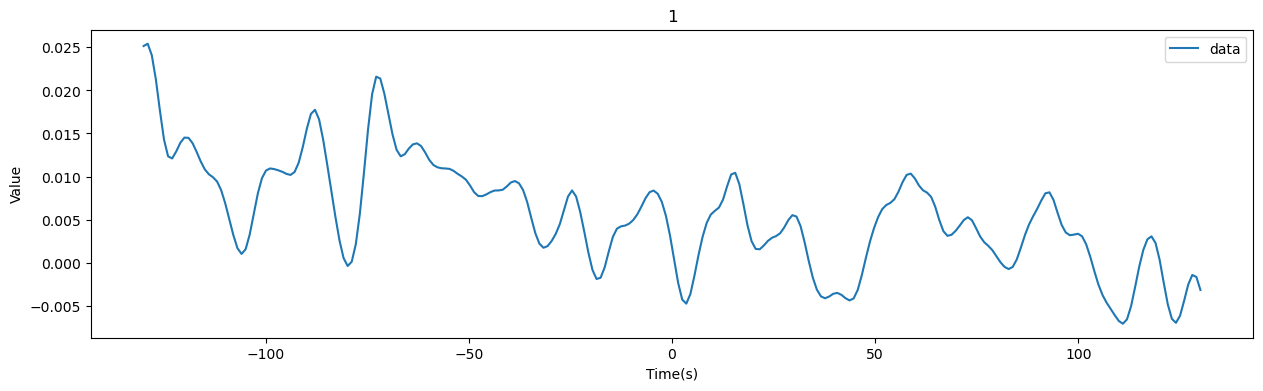

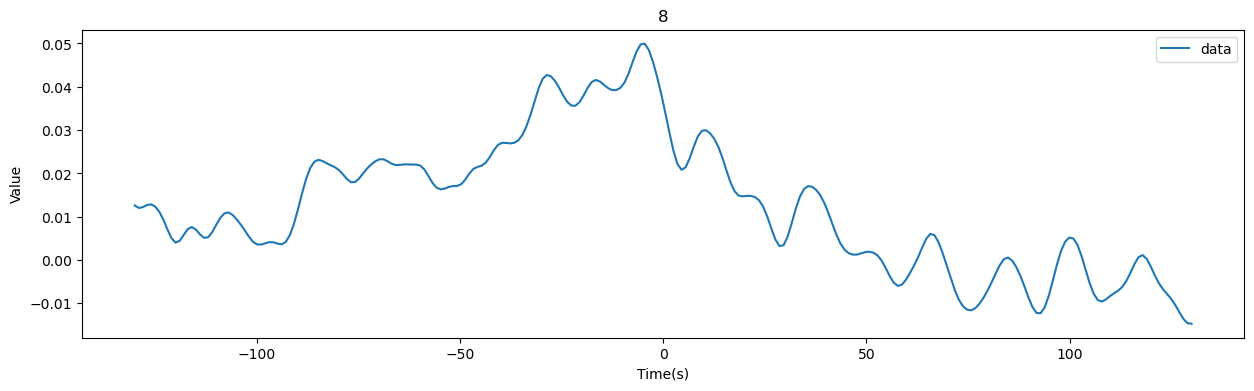

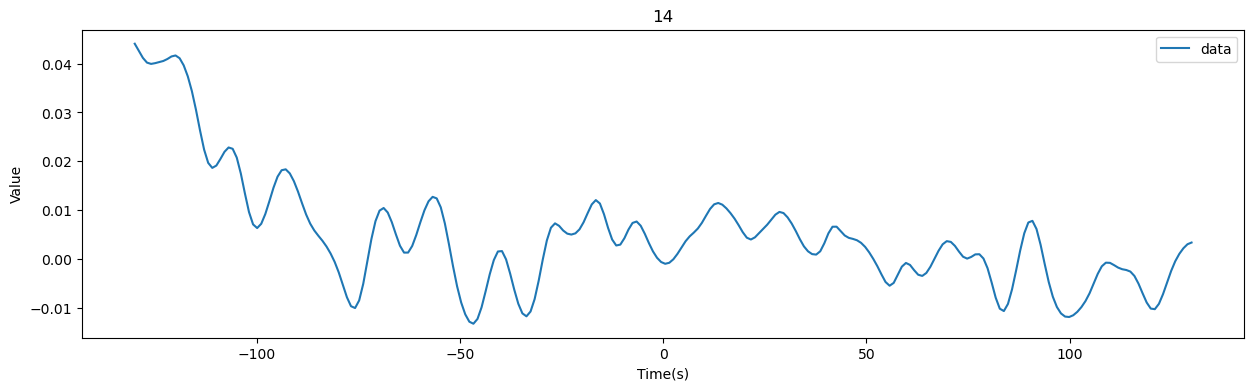

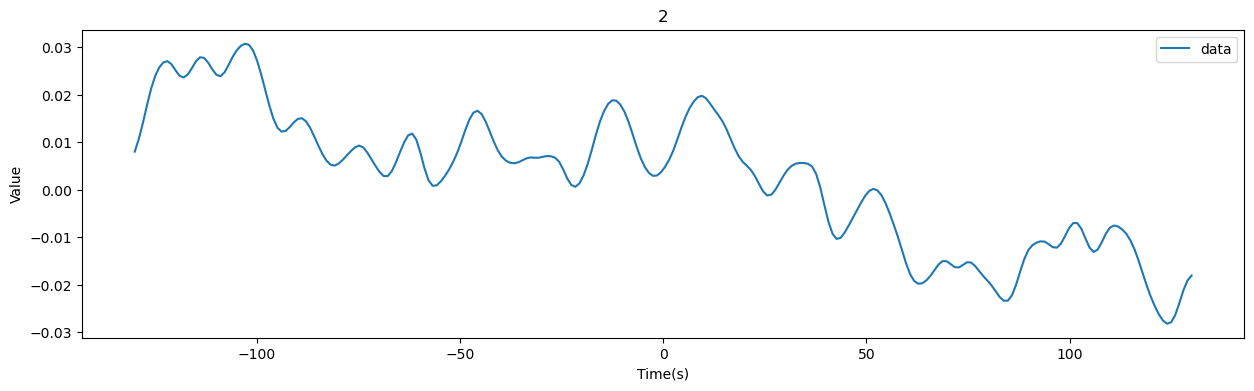

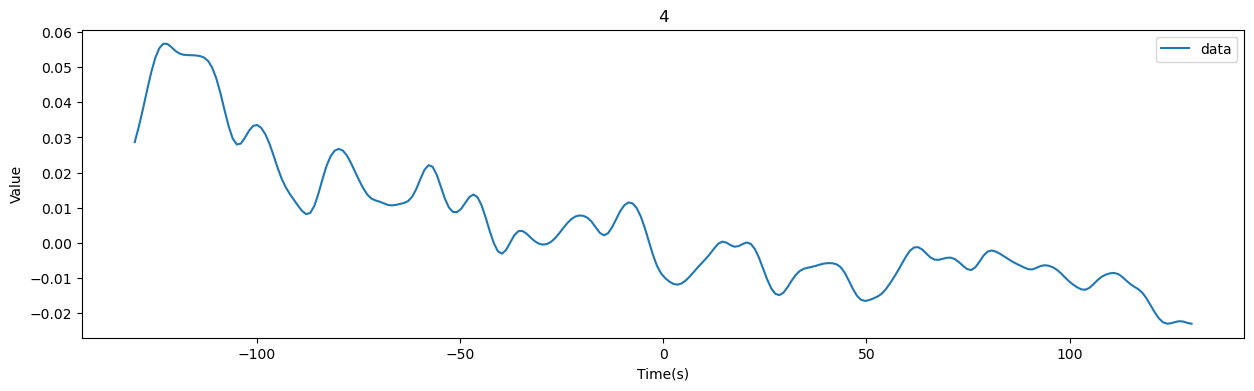

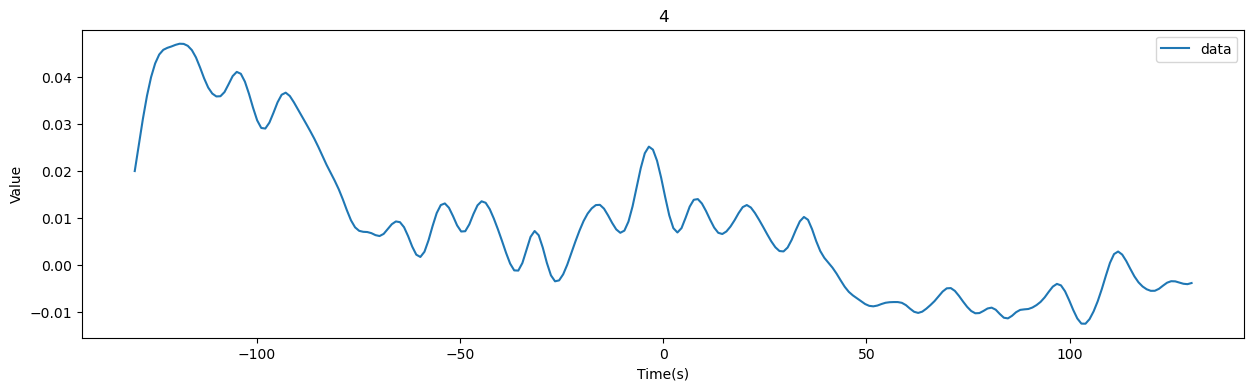

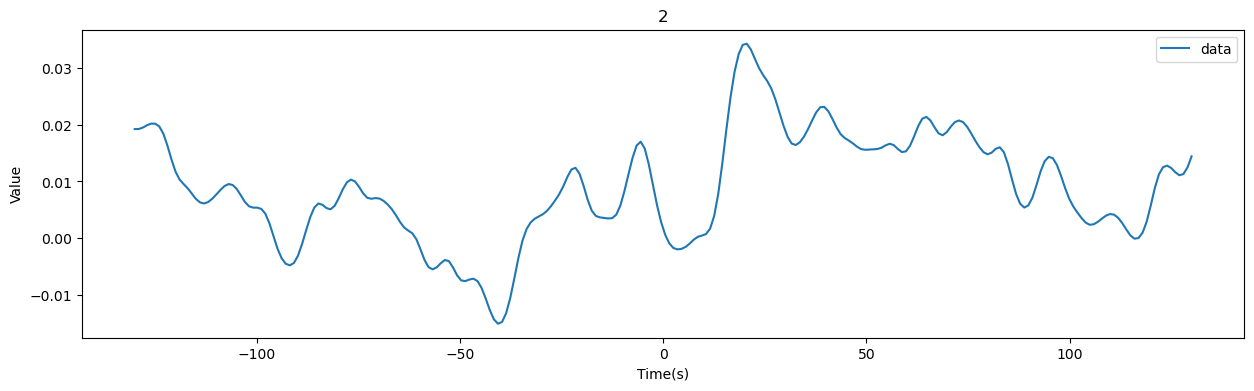

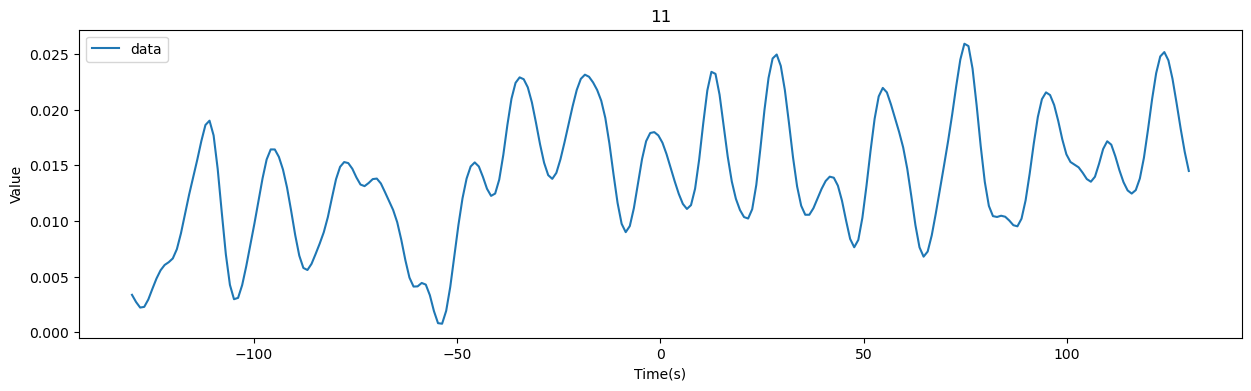

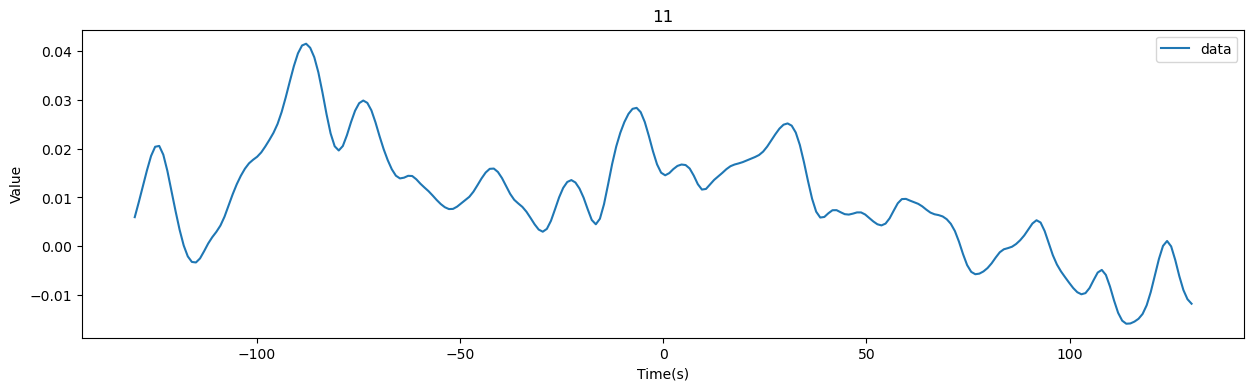

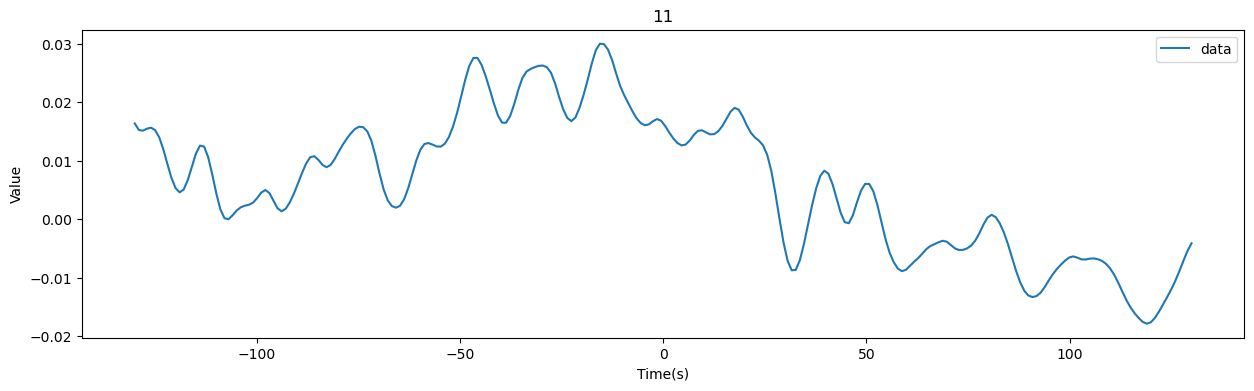

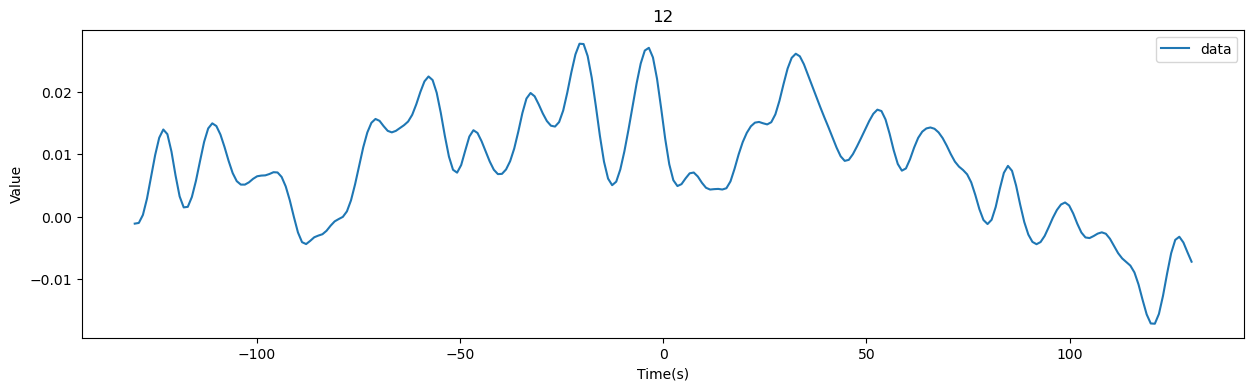

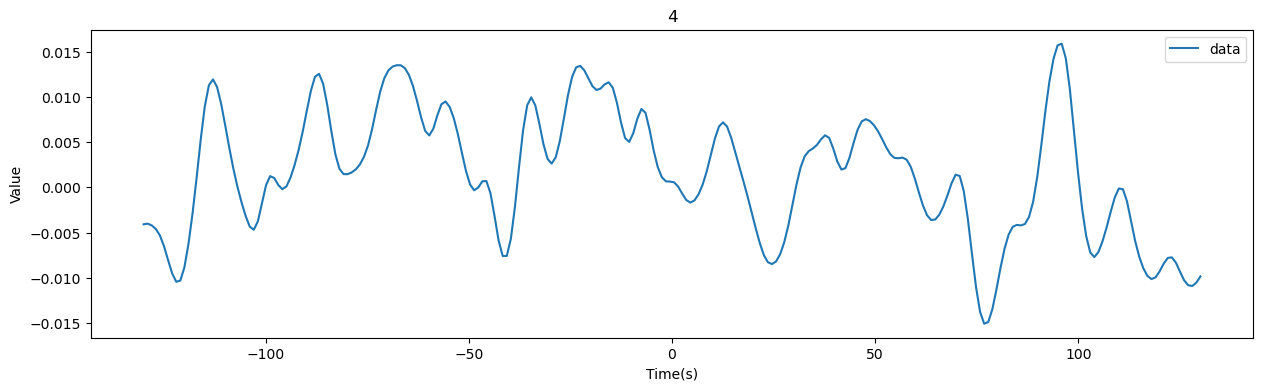

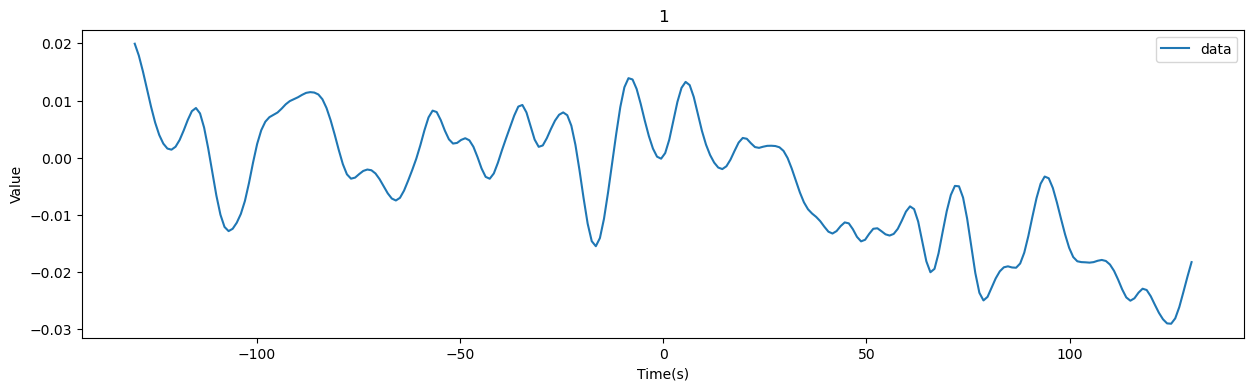

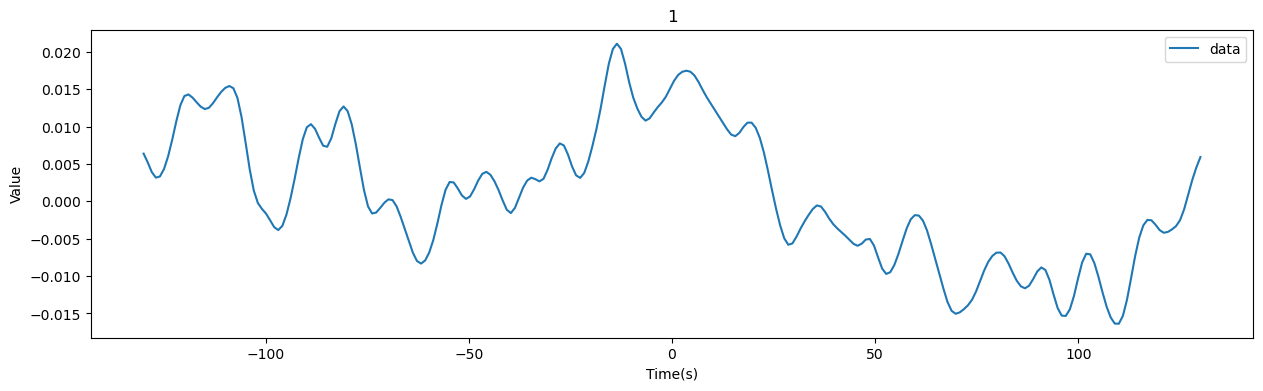

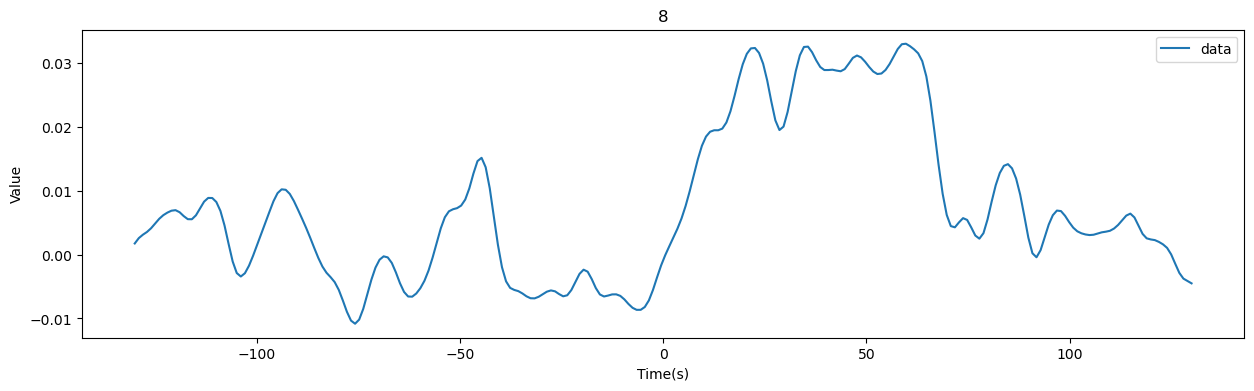

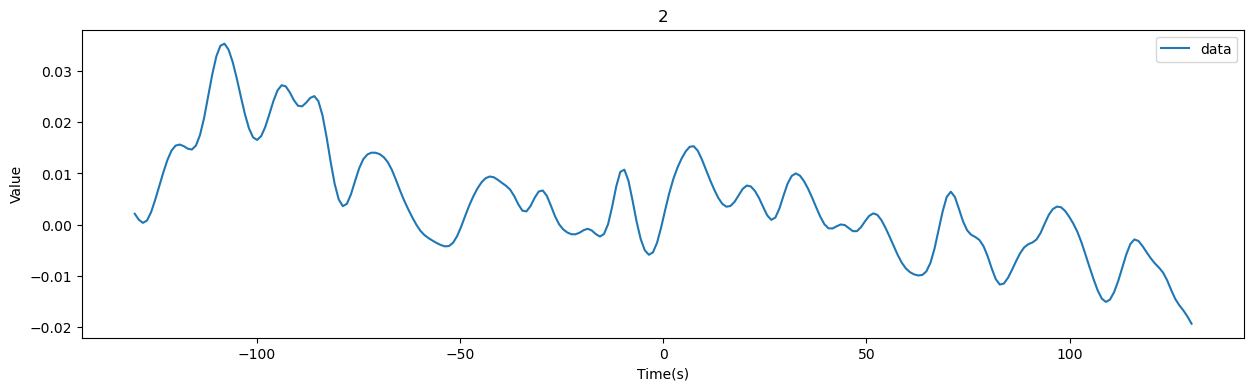

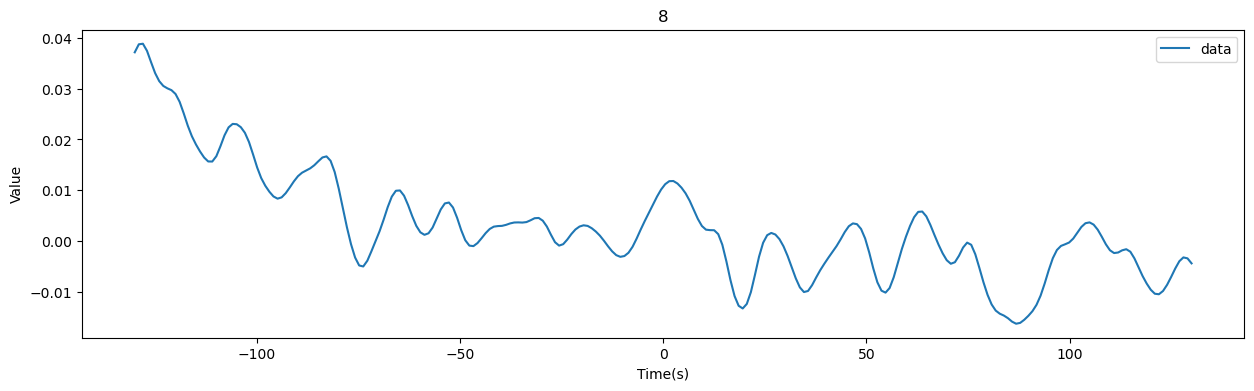

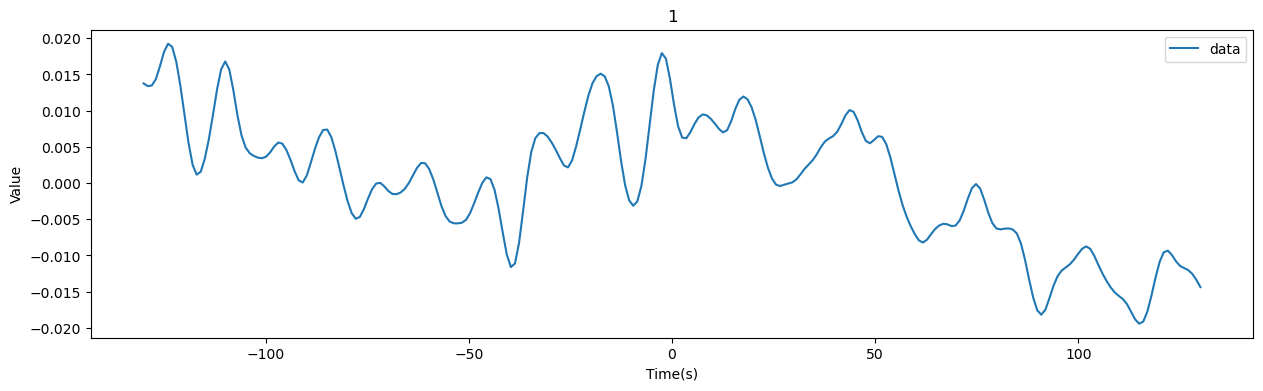

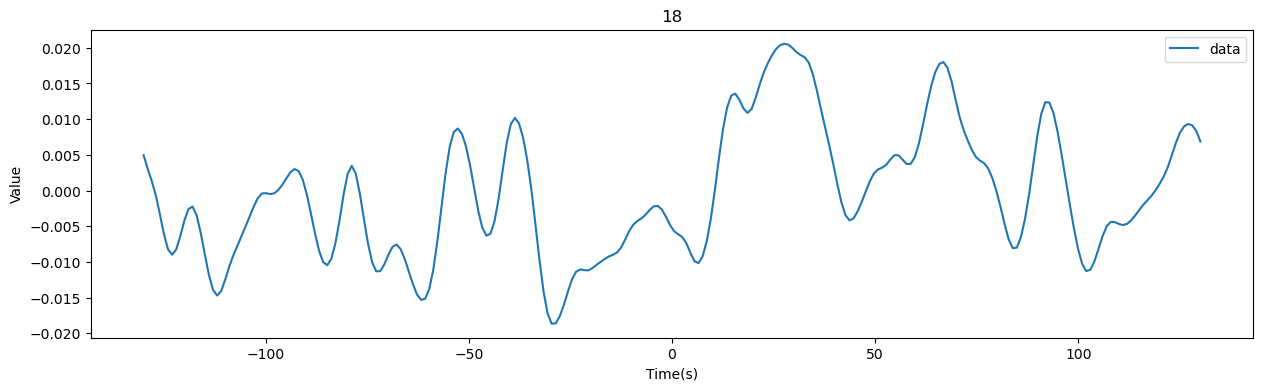

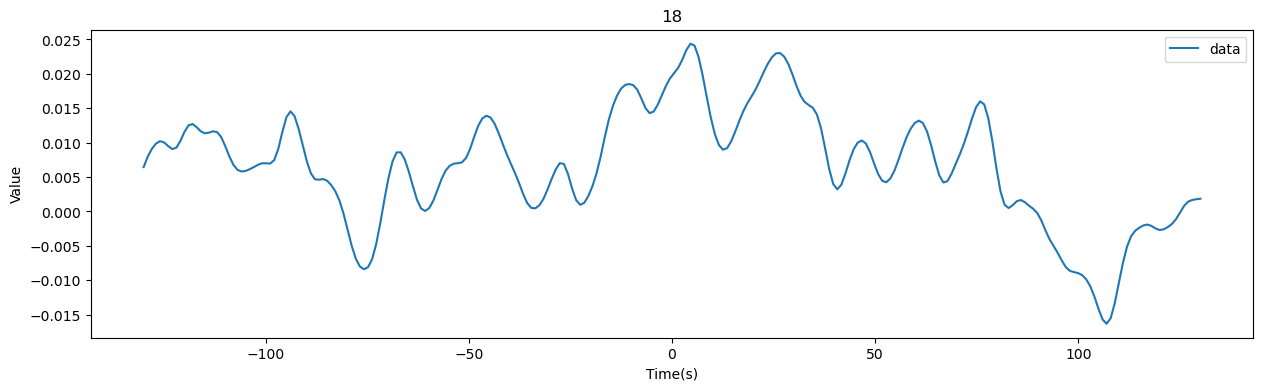

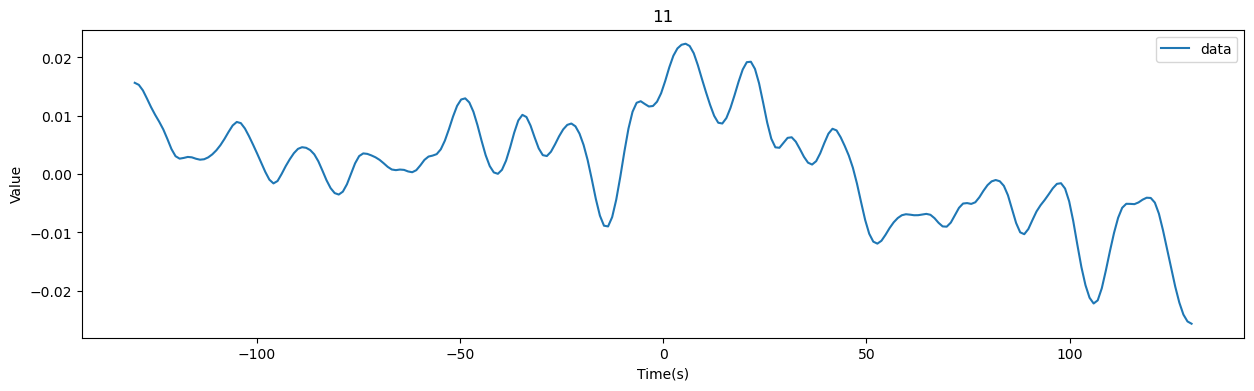

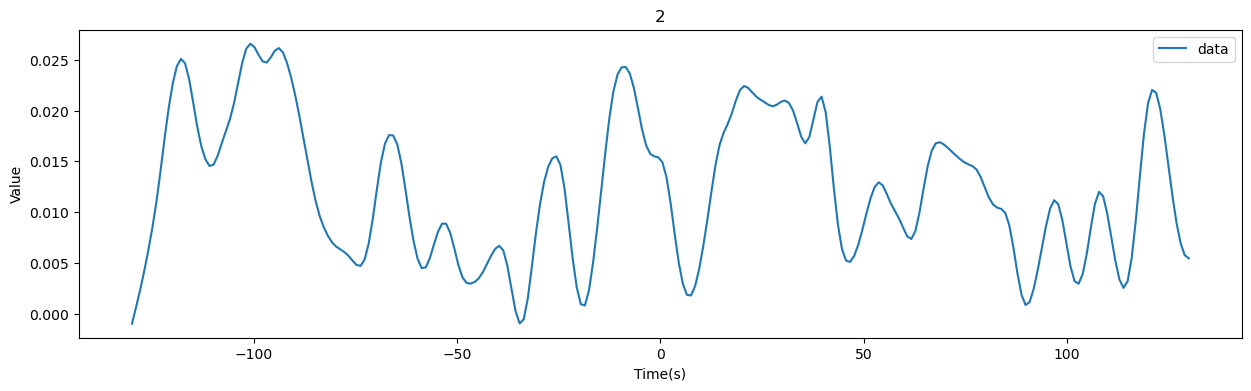

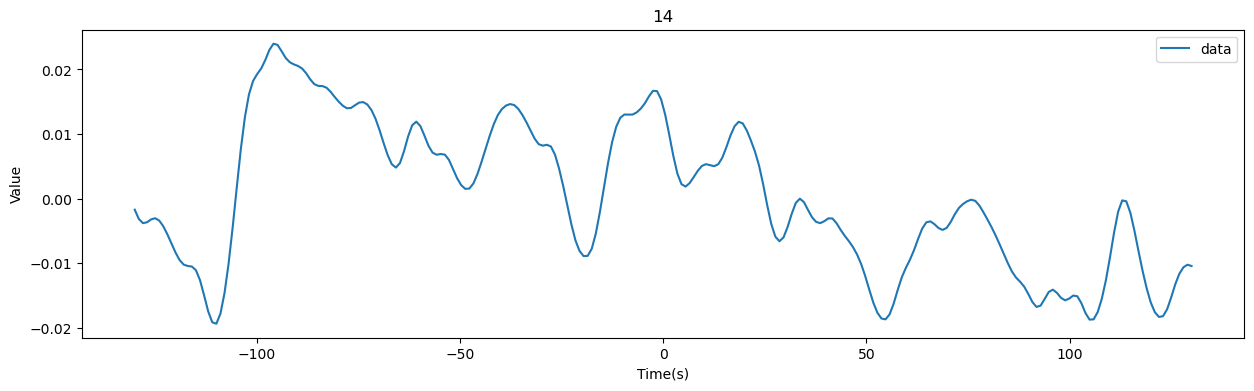

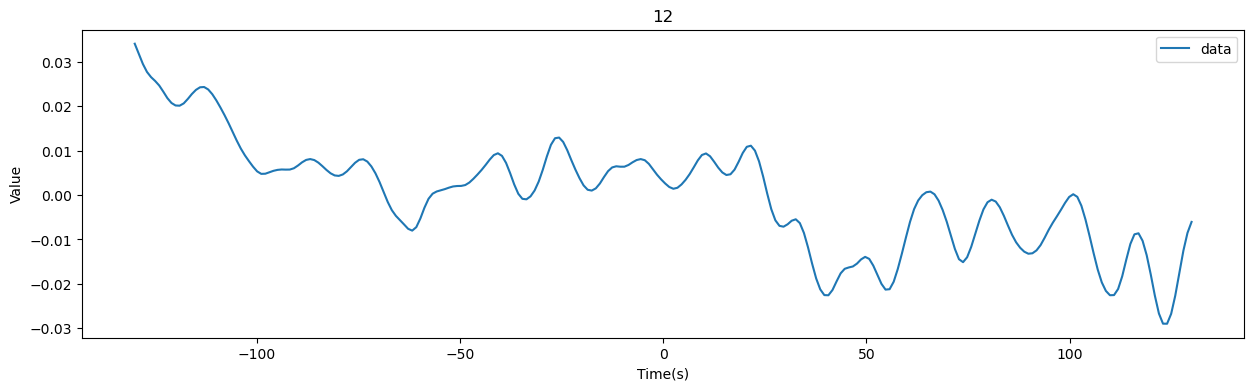

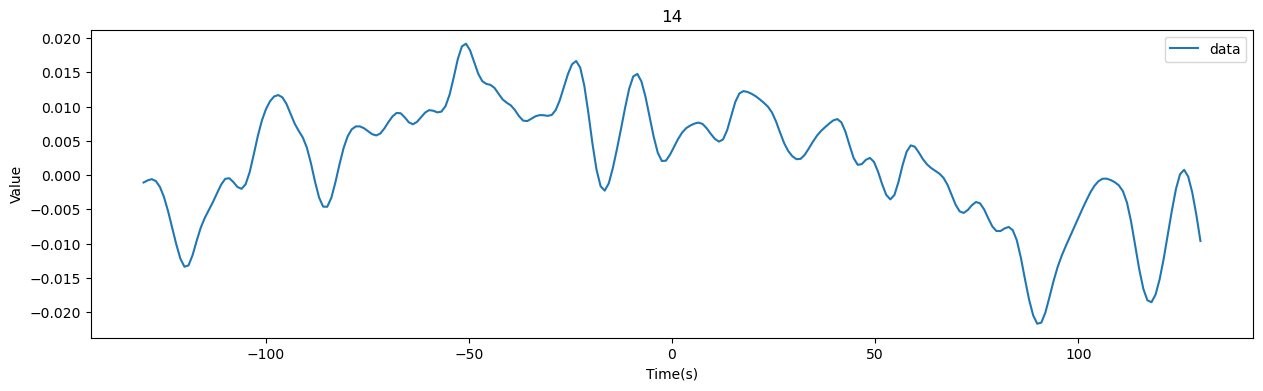

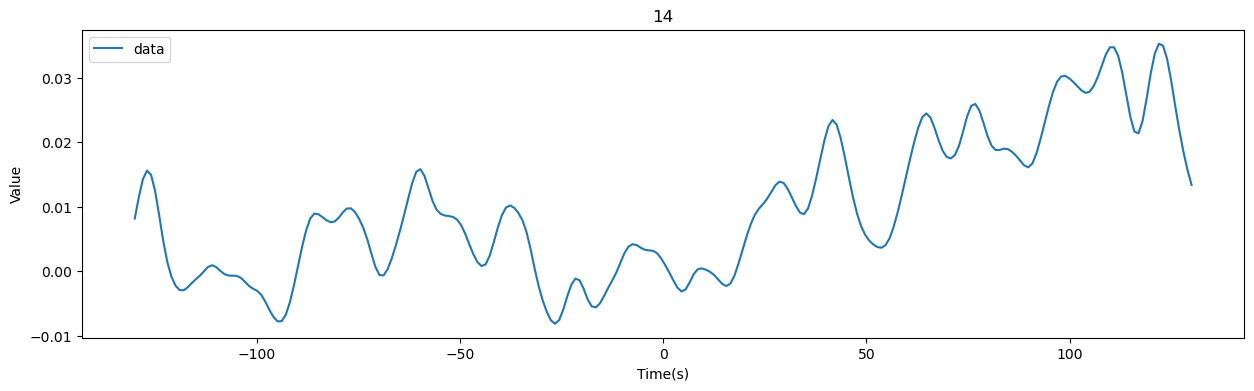

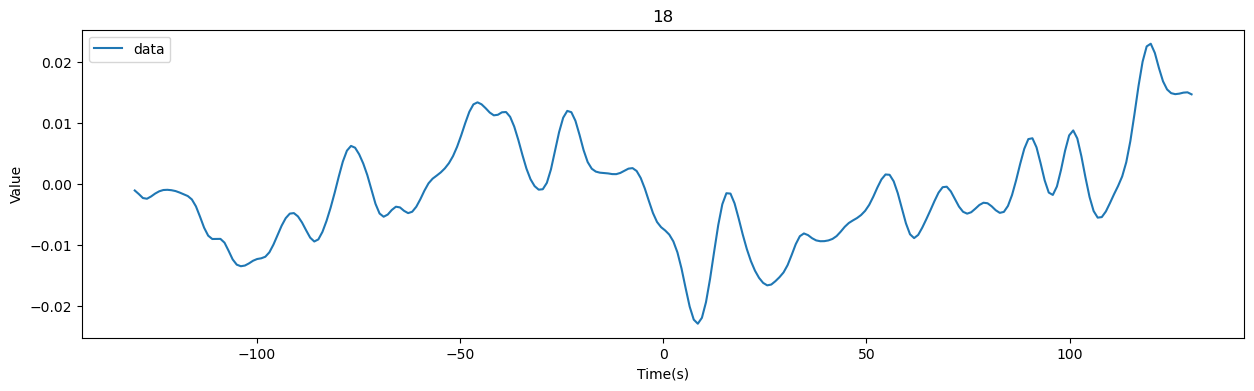

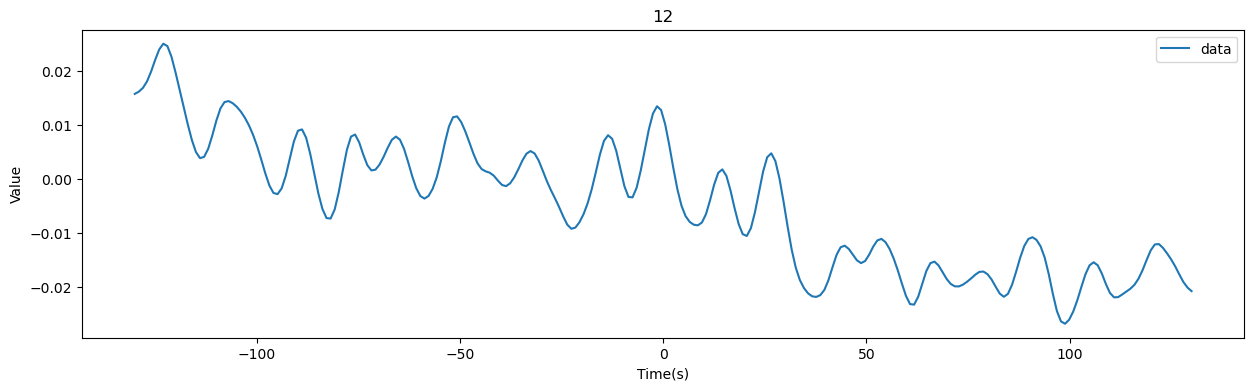

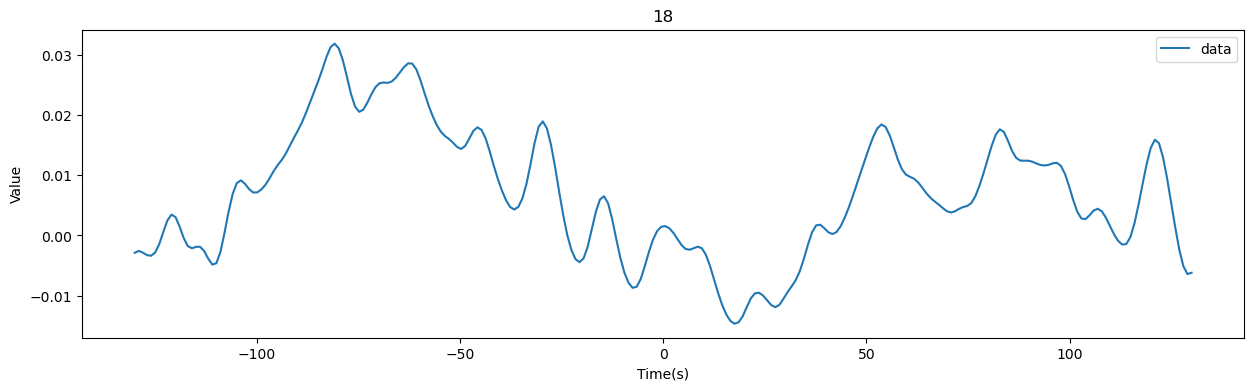

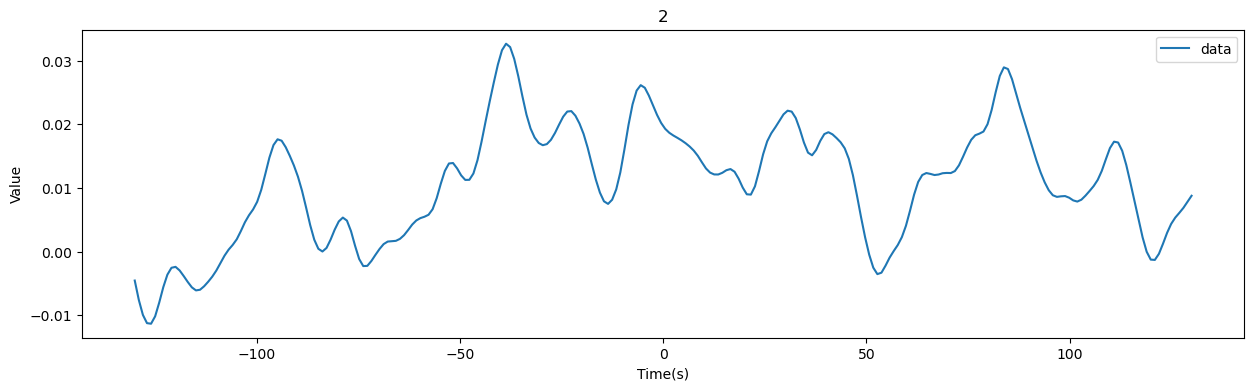

In [ ]:

# time = np.linspace(-130, 130, 260)
# for i, frame in enumerate(rewardStamps):
#     plt.figure(figsize=(15, 4))
#     # plt.plot(time, normalize(reward_binary[frame-30:frame+45]), label='reward')
#     plt.plot(time, (dff_dopamine_signal[frame-130:frame+130]), label='data')
#     plt.xlabel('Time(s)')
#     plt.ylabel('Value')
#     plt.title(f'{trialRewards[i]}')
#     plt.legend()
#     plt.show()



In [ ]:
# session_path_list = glob.glob('/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/interpolated&downsample/first_test_session/*')
# low_expectation_rp = []
# high_expectation_rp = []
# for session_path in session_path_list:
#     if 'low' in session_path:
#         with open(f'{session_path}/reversal_points.pkl', 'rb') as f:
#             reversal_points = pickle.load(f)
#         for neuron_idx in reversal_points.keys():
#             try:
#                 low_expectation_rp.append(reversal_points[neuron_idx][0])
#             except Exception as e:
#                 print(f"Skipping neuron {neuron_idx} due to error: {e}")
#             continue
#     if 'high' in session_path:
#         with open(f'{session_path}/reversal_points.pkl', 'rb') as f:
#             reversal_points = pickle.load(f)
#         for neuron_idx in reversal_points.keys():
#             try:
#                 high_expectation_rp.append(reversal_points[neuron_idx][0])
#             except Exception as e:
#                 print(f"Skipping neuron {neuron_idx} due to error: {e}")
#             continue

# plt.hist(low_expectation_rp, bins=8, range=(0, 18), edgecolor='black')
# # plt.hist(high_expectation_rp, bins=8, range=(0, 18), edgecolor='black')
# plt.ylim(0, 10)
# plt.xlabel('Reversal point')
# plt.ylabel('Frequency')
# plt.title('Low expectation')
# plt.show()

# plt.hist(high_expectation_rp, bins=8, range=(0, 18), edgecolor='black')
# plt.ylim(0, 10)
# plt.xlabel('Reversal point')
# plt.ylabel('Frequency')
# plt.title('High expectation')
# plt.show()

Skipping neuron 73 due to error: list index out of range


/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_84093/841474625.py:130: RuntimeWarning: divide by zero encountered in log
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_84093/841474625.py:130: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)


Neuron0 fitted
Neuron1 fitted
Neuron2 fitted
Neuron3 fitted
Neuron4 fitted
Neuron5 fitted
Neuron6 fitted
Neuron7 fitted
Neuron8 fitted
Neuron9 fitted
Neuron10 fitted
Neuron11 fitted
Neuron12 fitted
Neuron13 fitted
Neuron14 fitted
Neuron15 fitted
Neuron16 fitted
Neuron17 fitted
Neuron18 fitted
Neuron19 fitted
Neuron20 fitted
Neuron21 fitted
Neuron22 fitted
Neuron23 fitted
Neuron24 fitted
Neuron25 fitted
Neuron26 fitted
Neuron27 fitted
Neuron28 fitted
Neuron29 fitted
Neuron30 fitted
Neuron31 fitted
Neuron32 fitted
Neuron33 fitted
Neuron34 fitted
Neuron35 fitted
Neuron36 fitted
Neuron37 fitted
Neuron38 fitted
Neuron39 fitted
Neuron40 fitted
Neuron41 fitted
Neuron42 fitted
Neuron43 fitted
Neuron44 fitted
Neuron45 fitted
Neuron46 fitted
Neuron47 fitted
Neuron48 fitted
Neuron49 fitted
Neuron50 fitted
Neuron51 fitted
Neuron52 fitted
5-fold cross-validated Fraction Deviance Explained (FDE) for each neuron:
Overall mean Fraction Deviance Explained: -5.6366059407448943e+51
Saved model for neuron

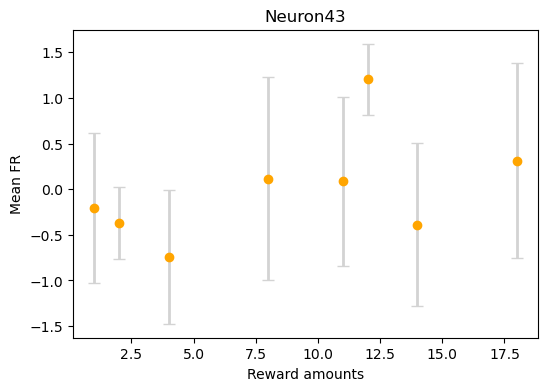

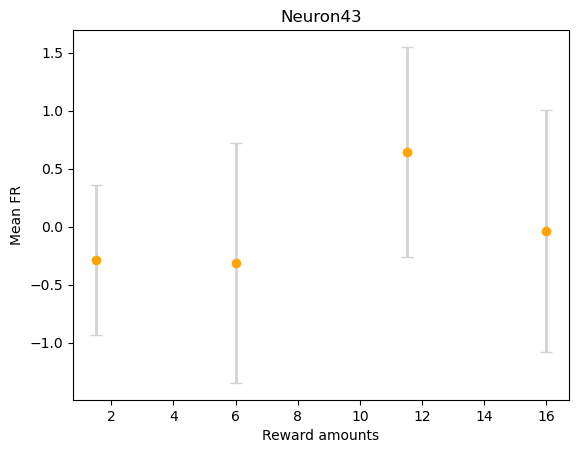

[7.807275640919649]
Neuron0 fitted


/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_84093/841474625.py:130: RuntimeWarning: divide by zero encountered in log
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_84093/841474625.py:130: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)


Neuron1 fitted
Neuron2 fitted
Neuron3 fitted
Neuron4 fitted
Neuron5 fitted
Neuron6 fitted
Neuron7 fitted
Neuron8 fitted
Neuron9 fitted
Skipping neuron 10 due to error: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping neuron 10 due to error: NaN, inf or invalid value detected in weights, estimation infeasible.
Neuron10 fitted


/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:447: RuntimeWa

Neuron11 fitted
Neuron12 fitted
Neuron13 fitted
Neuron14 fitted
Neuron15 fitted
Neuron16 fitted
Neuron17 fitted
Neuron18 fitted
Neuron19 fitted
Neuron20 fitted
Neuron21 fitted
Neuron22 fitted
Neuron23 fitted
Neuron24 fitted
Neuron25 fitted
Neuron26 fitted
Neuron27 fitted
Neuron28 fitted
Neuron29 fitted
Neuron30 fitted
Neuron31 fitted
Neuron32 fitted
Neuron33 fitted
Neuron34 fitted
Neuron35 fitted
Neuron36 fitted
Neuron37 fitted
5-fold cross-validated Fraction Deviance Explained (FDE) for each neuron:
Overall mean Fraction Deviance Explained: 0.05481078613817675
Saved model for neuron 0 to neuron_0_glm_model.pkl
Saved model for neuron 1 to neuron_1_glm_model.pkl
Saved model for neuron 2 to neuron_2_glm_model.pkl
Saved model for neuron 3 to neuron_3_glm_model.pkl
Saved model for neuron 4 to neuron_4_glm_model.pkl
Saved model for neuron 5 to neuron_5_glm_model.pkl
Saved model for neuron 6 to neuron_6_glm_model.pkl
Saved model for neuron 7 to neuron_7_glm_model.pkl
Saved model for neuron 8

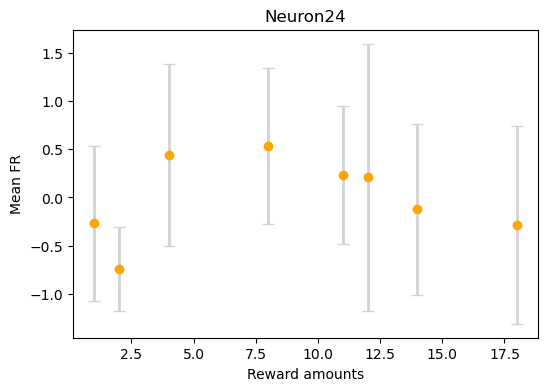

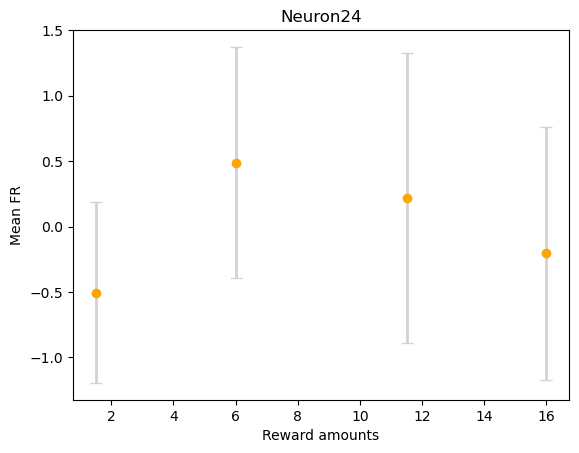

[3.786336855781899]


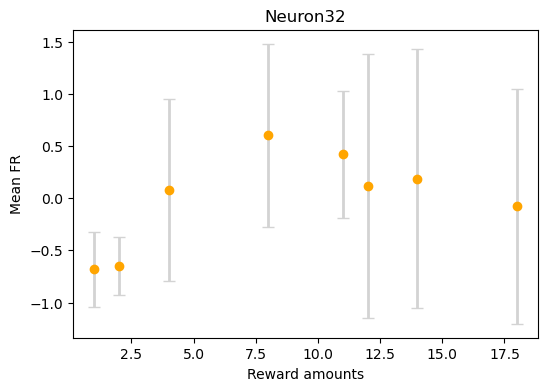

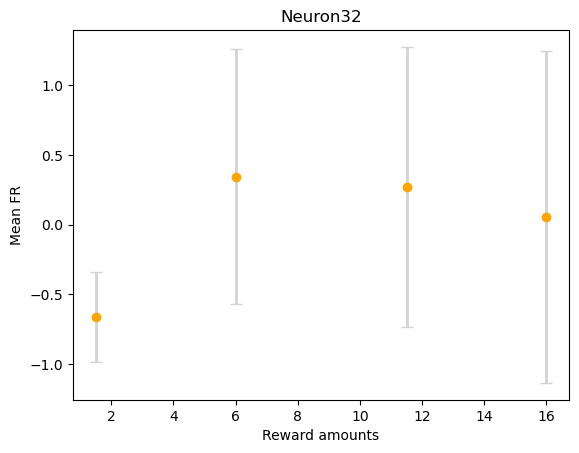

[4.472534359414246]


In [ ]:
mouse = 'ZZ0024-LR'
# date = '2024-08-28' # Remember to laod corresponding bpod data
# expectation = 'high'

date = '2024-08-16'
    date_in_bpod = date.replace("-", "")

    ### load wavesurfer stamps
    ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
    bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])

    ### load bpod results
    bpod_data = load_bpod_data(glob.glob(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse}/*{mouse}*{date_in_bpod}*')[0])
    trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])

    ### Exclude wrong trials
    wrongTrials = []
    for i, trial in enumerate(bpod_data['SessionData']['RawEvents']['Trial']):
        if trial['States']['WrongPort'][0]:
            wrongTrials.append(i)
    trialRewards = np.delete(trialRewards, wrongTrials)

    ### load minian results
    minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/new_parameters/{mouse}_{date}.netcdf")


    FS = 20000
    ### Handle sessions during which the wavesurfer crashed
    if len(bpod_trialstart_stamps) < 40:
        for i in range(len(bpod_trialstart_stamps), 40):
            next_stamp = bpod_trialstart_stamps[i-1] + bpod_data['SessionData']['RawEvents']['Trial'][i-1]['States']['EndState'][1] * FS
            bpod_trialstart_stamps = np.append(bpod_trialstart_stamps, next_stamp)
            
    bpod_trialstart_stamps = np.delete(bpod_trialstart_stamps, wrongTrials)

    if (len(minian_results.frame) - len(ms_stamps)) >= 150:
        for i in range(len(ms_stamps), len(minian_results.frame)):
            next_stamp = ms_stamps[i-1] + int(FS/30)
            ms_stamps = np.append(ms_stamps, next_stamp)


    calcium_traces = np.array(minian_results.C)
    spikes = np.array(minian_results.S)

    # rewardTimes = get_state_time('Reward', bpod_data)
    cueTimes = get_state_time('Tone', bpod_data)
    rewardTimes = get_state_time('Drinking', bpod_data)
    trialEnds = get_state_time('EndState', bpod_data)

    ws_rewardTimes = (rewardTimes)*FS + bpod_trialstart_stamps
    ms_rewardFrames = take_closest(ms_stamps, ws_rewardTimes)


    ws_trialEnds = (trialEnds)*FS + bpod_trialstart_stamps
    ms_trialEnds = take_closest(ms_stamps, ws_trialEnds)

    ms_trialstarts = take_closest(ms_stamps, bpod_trialstart_stamps)
    ms_rewardFrames = np.rint(ms_trialstarts + rewardTimes*30).astype(int)
    ms_cueFrames = np.rint(ms_trialstarts + cueTimes*30).astype(int)




    ### Get binary reward onset matrix
    cue_binary = np.zeros((calcium_traces.shape[1],1))
    cue_binary[ms_cueFrames] = 1


    reward_binary = np.zeros((calcium_traces.shape[1],1))
    plain_reward_binary = np.zeros((calcium_traces.shape[1],1))
    first_order_difference_reward_binary = np.zeros((calcium_traces.shape[1],1))
    for i, frame in enumerate(ms_rewardFrames):
        reward_binary[frame] = trialRewards[i]
        plain_reward_binary[frame] = 1
        if i == 0:
            first_order_difference_reward_binary[frame] = trialRewards[i]
        else:
            first_order_difference_reward_binary[frame] = trialRewards[i] - trialRewards[i-1]



    history_3trial_difference_binary = np.zeros((calcium_traces.shape[1],1))
    for i, frame in enumerate(ms_rewardFrames):
        if i == 0:
            history_3trial_difference_binary[frame] = trialRewards[i]
        elif i == 1:
            history_3trial_difference_binary[frame] = trialRewards[i] - trialRewards[i-1]
        elif i == 2:
            history_3trial_difference_binary[frame] = trialRewards[i] - (trialRewards[i-1] + trialRewards[i-2])/2
        else:
            history_3trial_difference_binary[frame] = trialRewards[i] - (trialRewards[i-1] + trialRewards[i-2] + trialRewards[i-3])/3


    # ### Get port encoded in one hot encode
    # trialPorts = bpod_data['SessionData']['TrialTypes']
    # port_onehot = np.zeros((calcium_traces.shape[1],8))

    # for i, trialPort in enumerate(trialPorts):
    #     port_onehot[ms_trialstarts[i]:ms_trialEnds[i],trialPort-1] = 1


    n_basis = 13             # Number of basis functions
    window_length_frames = 90  # For example, a window of 30 frames (which is 1 second at 30 fps)
    dt = 1                   # Since the data is frame-based, each unit represents one frame

    # Create the basis functions
    t, basis_set = create_raised_cosine_basis(n_basis, window_length_frames, dt)

    # Plot the basis functions
    # plt.figure(figsize=(8, 4))
    # for i in range(n_basis):
    #     plt.plot(t, basis_set[i], label=f'Basis {i+1}')
    # plt.xlabel('Frame')
    # plt.ylabel('Amplitude')
    # plt.title('Raised Cosine Basis Functions (Frame-Based)')
    # plt.legend()
    # plt.show()

    ### Smooth binary reward onset using exponential decay function
    tau = 60
    kernel_length = int(6 * tau)
    if kernel_length % 2 == 0:
        kernel_length += 1  # ensure odd length for symmetry

    # Create the kernel over 0 to kernel_length frames.
    t_kernel = np.arange(kernel_length)
    exp_kernel = np.exp(-t_kernel / tau)
    reward_smoothed = convolve(reward_binary.flatten(), exp_kernel, mode='full')[:reward_binary.shape[0]].reshape(-1,1)
    plain_reward_smoothed = convolve(plain_reward_binary.flatten(), exp_kernel, mode='full')[:plain_reward_binary.shape[0]].reshape(-1,1)
    first_order_difference_reward_smoothed = convolve(first_order_difference_reward_binary.flatten(), exp_kernel, mode='full')[:first_order_difference_reward_binary.shape[0]].reshape(-1,1)
    history_3trial_difference_smoothed = convolve(history_3trial_difference_binary.flatten(), exp_kernel, mode='full')[:history_3trial_difference_binary.shape[0]].reshape(-1,1)
    cue_smoothed = convolve(cue_binary.flatten(), exp_kernel, mode='full')[:cue_binary.shape[0]].reshape(-1,1)
    ### Create intercept matrix
    intercept = np.ones((calcium_traces.shape[1], 1))

    ### Stack all the matrices above to get final design matrix
    design_matrix = np.hstack([intercept, reward_smoothed])






    # -------------------------------
    # Set parameters for demonstration.
    # Replace these with your actual design matrix and response data.
    n_frames = calcium_traces.shape[1]        # total number of frames in the session
    n_predictors = 2       # e.g., intercept + 8 port condition columns + reward regressor
    n_neurons = calcium_traces.shape[0]         # number of neurons

    # For demonstration purposes, create dummy data.
    # For Poisson regression, the response must be nonnegative integers.
    np.random.seed(42)
    X_input = reward_smoothed
    X_data = sm.add_constant(X_input)  # Your actual design matrix
    #Y_data = calcium_traces  # Simulated count data
    Y_data = spikes  # Simulated count data
    # -------------------------------
    # 10-Fold Cross Validation for performance evaluation (Poisson GLM)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    all_neuron_r2 = np.zeros(n_neurons)

    # Initialize an array to store the cross-validated fraction deviance explained (FDE) for each neuron.
    all_neuron_fde = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):
        y_neuron = Y_data[neuron_idx, :]  # Get the count data for this neuron (length = n_frames)
        fold_fde = []
        
        # Iterate through the 10 folds.
        for train_index, test_index in kf.split(X_data):
            X_train, X_test = X_data[train_index, :], X_data[test_index, :]
            y_train, y_test = y_neuron[train_index], y_neuron[test_index]
            
            # Fit the Poisson GLM (default link is log).
            model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
            try:
                result = model.fit()
            except Exception as e:
                print(f"Skipping neuron {neuron_idx} due to error: {e}")
                continue

            # Predict the expected counts on the test set.
            y_pred = result.predict(X_test)
            
            # Compute the deviance of the fitted model on the test set.
            dev_model = poisson_deviance(y_test, y_pred)
            
            # Compute the null deviance.
            # Here we use the mean of the training data as the prediction for all test observations.
            y_null = np.full_like(y_test, np.mean(y_train))
            dev_null = poisson_deviance(y_test, y_null)
            
            # Compute the fraction of deviance explained for this fold.
            # (Check that dev_null is not zero to avoid division by zero.)
            fde = 1 - dev_model / dev_null if dev_null != 0 else np.nan
            fold_fde.append(fde)
        
        # Average the FDE values over the 10 folds for this neuron.
        all_neuron_fde[neuron_idx] = np.mean(fold_fde)
        print(f"Neuron{neuron_idx} fitted")

    # Report the cross-validated fraction deviance explained for each neuron.
    print("5-fold cross-validated Fraction Deviance Explained (FDE) for each neuron:")
    # print(all_neuron_fde)

    # Optionally, compute the overall mean FDE across neurons.
    mean_fde = np.mean(all_neuron_fde)
    print("Overall mean Fraction Deviance Explained:", mean_fde)

    final_models = {}

    for neuron_idx in range(n_neurons):
        y_neuron = Y_data[neuron_idx, :]
        model = sm.GLM(y_neuron, X_data, family=sm.families.Poisson())
        try:
            result = model.fit()

            # Option 1: Use statsmodels' built-in save method
            filename = f'neuron_{neuron_idx}_glm_model.pkl'
            folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/reward_amounts'
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            result.save(os.path.join(folder_path,filename))
            print(f"Saved model for neuron {neuron_idx} to {filename}")
        except Exception as e:
            print(f"Skipping neuron {neuron_idx} due to error: {e}")
            continue
        if result:
            final_models[neuron_idx] = result

    with open(os.path.join(folder_path,"all_neuron_glm_models.pkl"), "wb") as f:
        pickle.dump(final_models, f)
    print("Saved all neuron models to all_neuron_glm_models.pkl")

    np.save(os.path.join(folder_path, "all_neuron_fde.npy"), all_neuron_fde)
    np.save(os.path.join(folder_path, 'RPE_relative_neuron_id.npy'), np.where(all_neuron_fde > 0.2)[0])



    reward_pairs = {
        1.5:[1,2],
        6:[4,8],
        11.5:[11,12],
        16:[14,18]
    }

    reversal_points = {}

    selected_neurons = np.where(all_neuron_fde > 0.2)[0]
    reward_amounts = [1,2,4,8,11,12,14,18]

    folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/interpolated&downsample/{mouse}_{date}/'
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    meanFR_reward = np.zeros([spikes.shape[0],40])
    for i in range(40):
        meanFR_reward[:,i] = spikes[:,ms_rewardFrames[i]+5:ms_rewardFrames[i]+45].mean()
    z_scored_meanFR_reward = z_score(meanFR_reward)

    for neuron_idx in selected_neurons:
        firing_rate = spikes[neuron_idx,:]
        singleneuron_meanFR_reward = np.zeros(40)
        for i in range(40):
            singleneuron_meanFR_reward[i] = firing_rate[ms_rewardFrames[i]+5:ms_rewardFrames[i]+45].mean() - firing_rate[ms_rewardFrames[i]-15:ms_rewardFrames[i]].mean() 
        zscored_singleneuron_meanFR = z_score(singleneuron_meanFR_reward, axis=0)

        # score_total = {}
        # for reward_amount in reward_amounts:
        #     score = 0
        #     greater_reward_trials = np.where(trialRewards>reward_amount)[0]
        #     less_reward_trials = np.where(trialRewards<reward_amount)[0]
        #     if greater_reward_trials.size > 0:
        #         for t in greater_reward_trials:
        #             if zscored_singleneuron_meanFR[t] > 0:
        #                 score +=1
        #     if less_reward_trials.size > 0:
        #         for t in less_reward_trials:
        #             if zscored_singleneuron_meanFR[t] < 0:
        #                 score += 1
        #     score_total[reward_amount] = score
        #     folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/Dabney_scores/{mouse}_{date}/'
        #     if not os.path.isdir(folder_path):
        #         os.makedirs(folder_path)
        #     with open(f'/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/Dabney_scores/{mouse}_{date}/neuron{neuron_idx}.pkl', 'wb') as f:
        #         pickle.dump(score_total, f)
        # print(score_total)
        # reversal_point = max(score_total, key=score_total.get)
        # print(reversal_point)


        plt.figure(figsize=(6, 4))

        for reward_amount in reward_amounts:
            mean = np.mean(zscored_singleneuron_meanFR[trialRewards == reward_amount])
            std = np.std(zscored_singleneuron_meanFR[trialRewards == reward_amount])
            #plt.scatter(reward_amount, mean, color='orange', s=50)
            plt.errorbar(reward_amount, mean, yerr=std, fmt='o', color='orange', ecolor='lightgray', elinewidth=2, capsize=4)
        plt.xlabel('Reward amounts')
        plt.ylabel('Mean FR')
        plt.title(f'Neuron{neuron_idx}')
        plt.savefig(f'{folder_path}neuron{neuron_idx}_saperate')
        plt.show()


        means = []
        for value in reward_pairs:
            mean = np.mean(zscored_singleneuron_meanFR[(trialRewards == reward_pairs[value][0]) | (trialRewards == reward_pairs[value][1])])
            means.append(mean)
            std = np.std(zscored_singleneuron_meanFR[(trialRewards == reward_pairs[value][0]) | (trialRewards == reward_pairs[value][1])])
            #plt.scatter(reward_amount, mean, color='orange', s=50)
            plt.errorbar(value, mean, yerr=std, fmt='o', color='orange', ecolor='lightgray', elinewidth=2, capsize=4)
        plt.title(f'Neuron{neuron_idx}')
        plt.xlabel('Reward amounts')
        plt.ylabel('Mean FR')
        plt.savefig(f'{folder_path}neuron{neuron_idx}')
        plt.show()

        means = np.array(means)
        reversal_point = find_all_zero_crossings(np.array(list(reward_pairs.keys())), means)
        print(reversal_point)
        reversal_points[neuron_idx] = reversal_point

    with open(f'{folder_path}reversal_points.pkl', 'wb') as f:
        pickle.dump(reversal_points, f)

    np.save(f'{folder_path}zscored_meanFR_drinking_onset.npy', z_scored_meanFR_reward)

### GLM from Harvey

In [1235]:
# import numpy as np
# import scipy.stats
# from sklearn.model_selection import train_test_split, GroupShuffleSplit
# import tensorflow as tf
# import matplotlib
# import matplotlib.pyplot as plt
# import glm_class as glm


# X_data = design_matrix
# Y_data = calcium_traces
# n_neurons = calcium_traces.shape[0]
# all_neuron_fde = np.zeros(n_neurons)
# folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# for neuron_idx, neuron_trace in enumerate(calcium_traces):
#     # Reset keras states
#     tf.keras.backend.clear_session()

#     # Initialize GLM_CV (here I'm listing out all input arguments, but many of them can be left with default values)
#     model_cv = glm.GLM_CV(n_folds = 5, auto_split = True, split_by_group = False, split_random_state = 42,
#                         activation = 'linear', loss_type = 'gaussian', 
#                         regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(3, -6, 10), 
#                         l1_ratio = 0., smooth_strength = 0., 
#                         optimizer = 'adam', learning_rate = 1e-2, momentum = 0.5, 
#                         min_iter_per_lambda = 100, max_iter_per_lambda = 10**4, 
#                         num_iter_check = 100, convergence_tol = 1e-6)
#     model_cv.fit(X_data, neuron_trace, verbose=False)
#     # Select the model using 1SE rule and given minimal lambda
#     model_cv.select_model(se_fraction = 1, min_lambda = 1e-5, make_fig = False)
#     fold_fde = model_cv.selected_frac_dev_expl_cv
#     all_neuron_fde[neuron_idx] = np.mean(fold_fde)
#     print(f"Neuron{neuron_idx} fitted")

# np.save(os.path.join(folder_path, "all_neuron_fde_Harvey.npy"), all_neuron_fde)


### GLM from statsmodel

/Users/fgs/HMLworkplace/diversity_expt/analysis_pkg/tools/util.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_arr = (arr - arr_min) / (arr_max - arr_min)


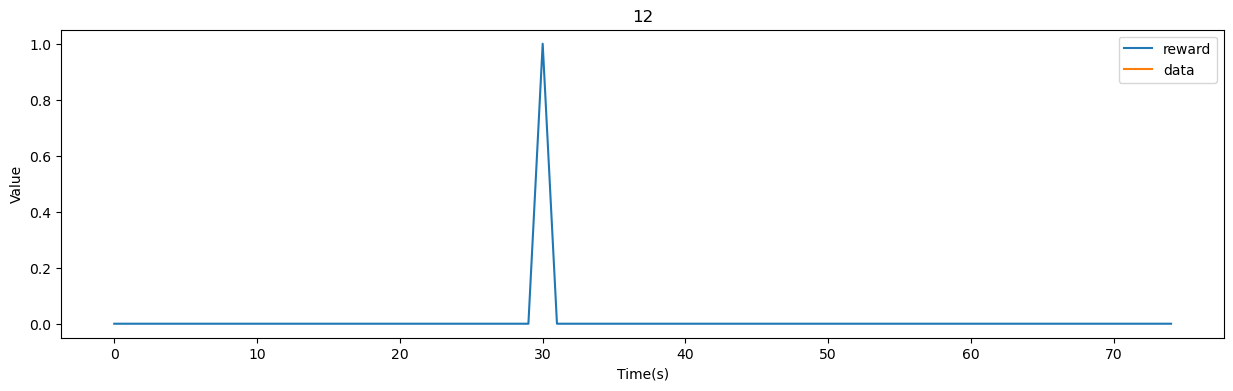

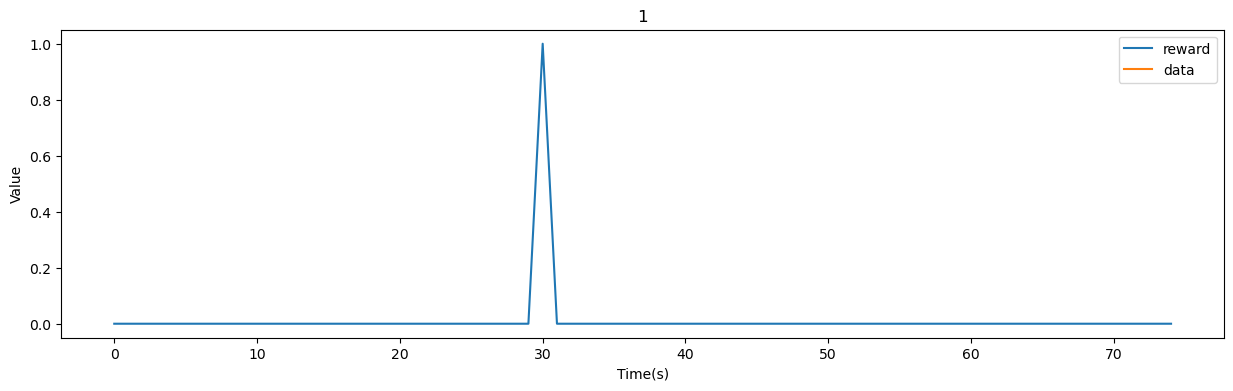

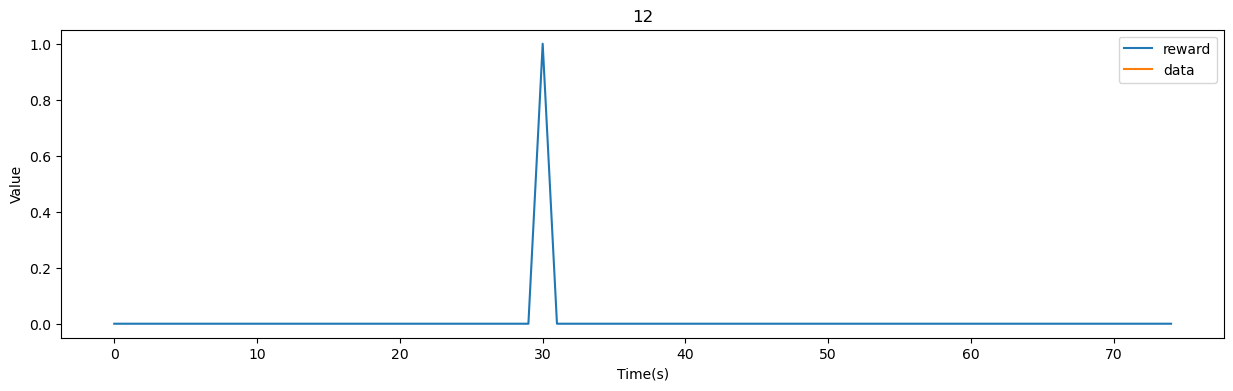

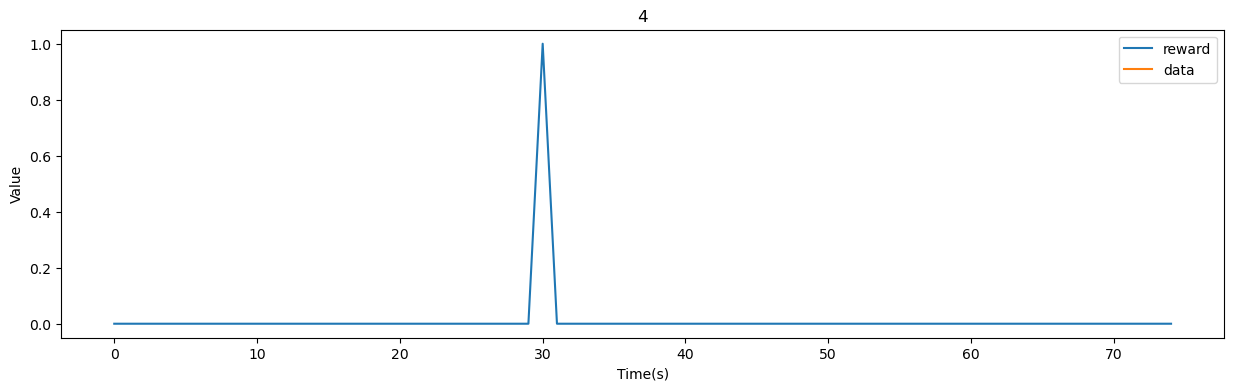

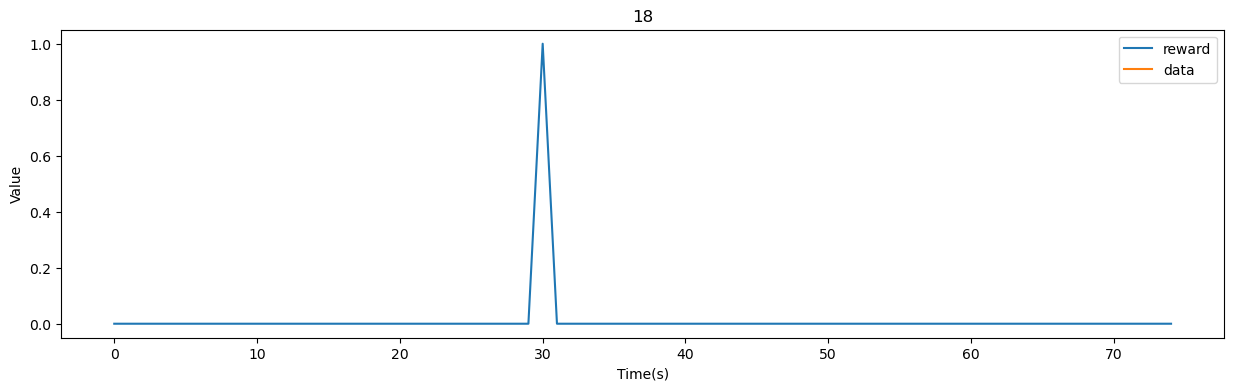

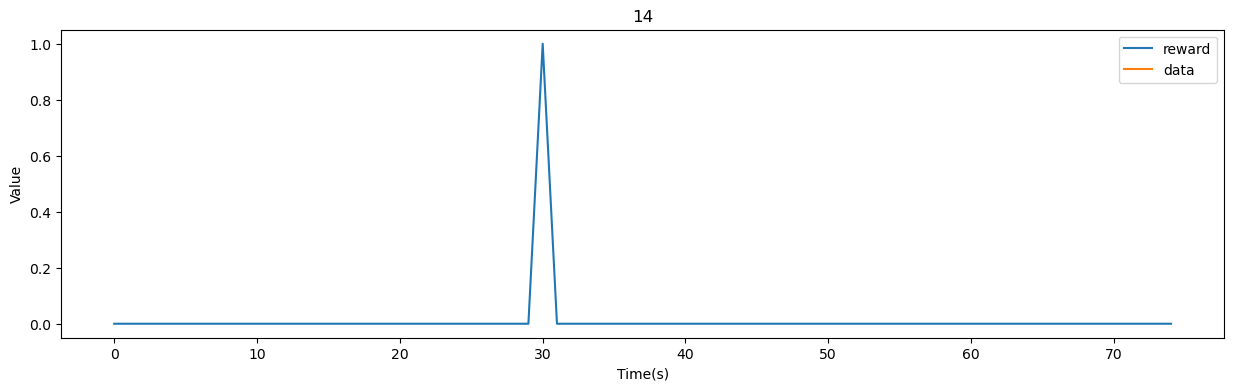

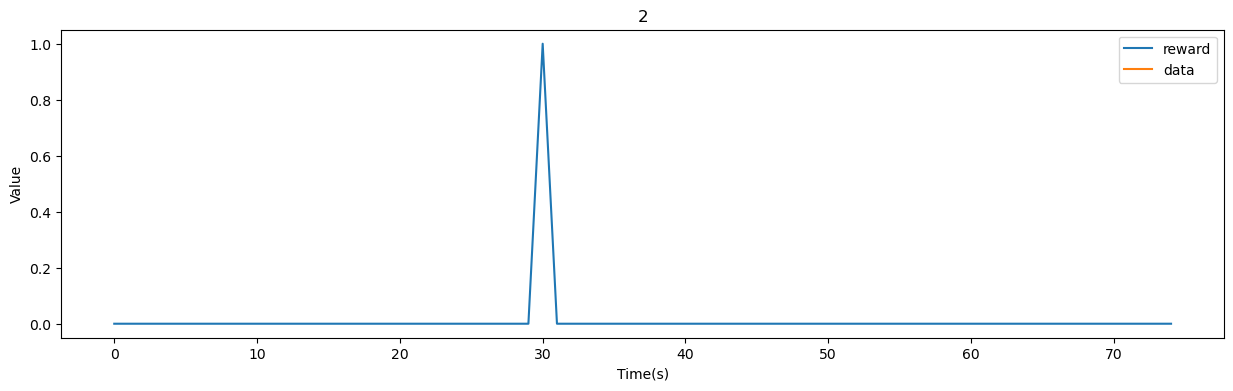

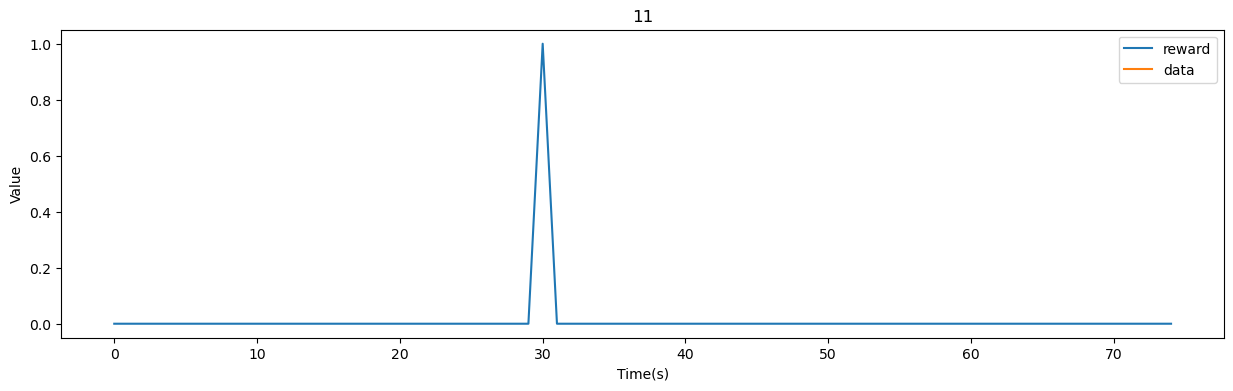

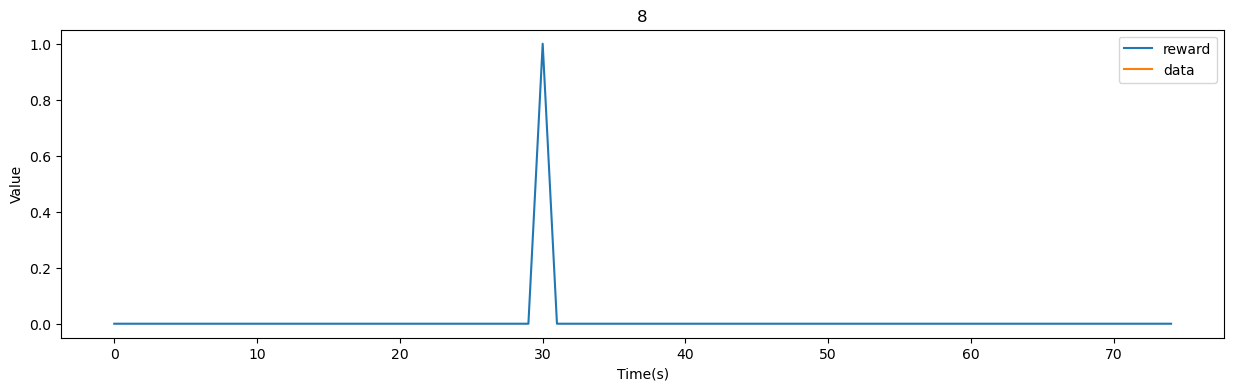

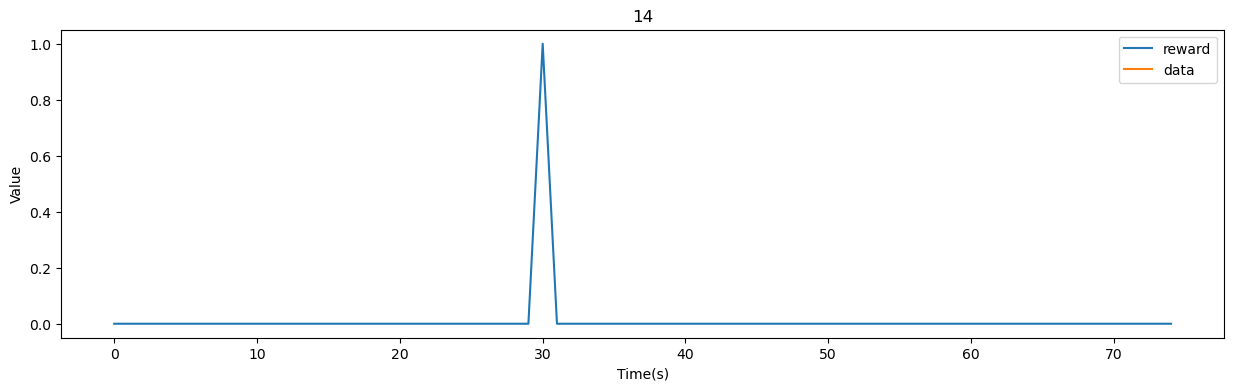

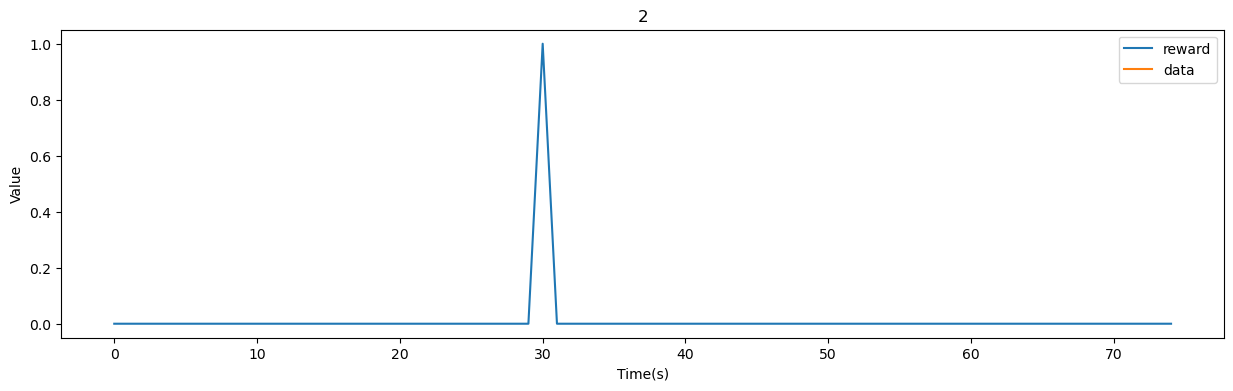

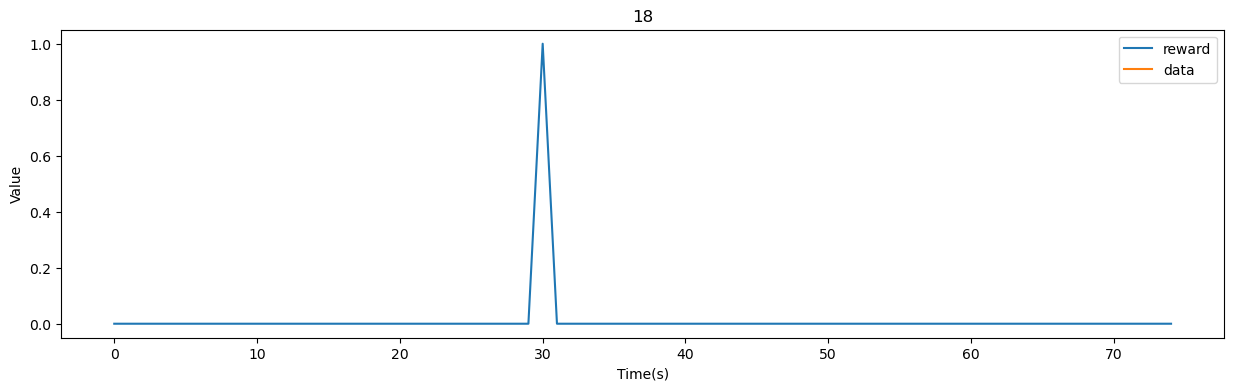

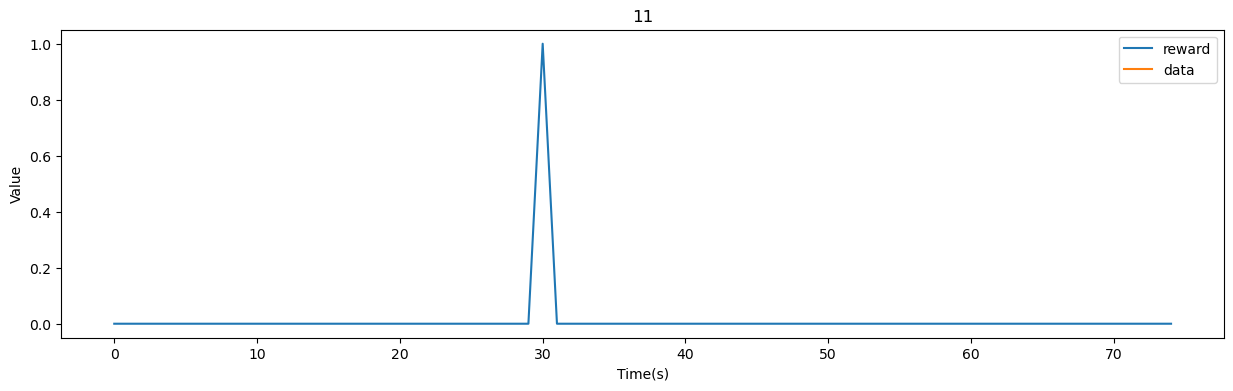

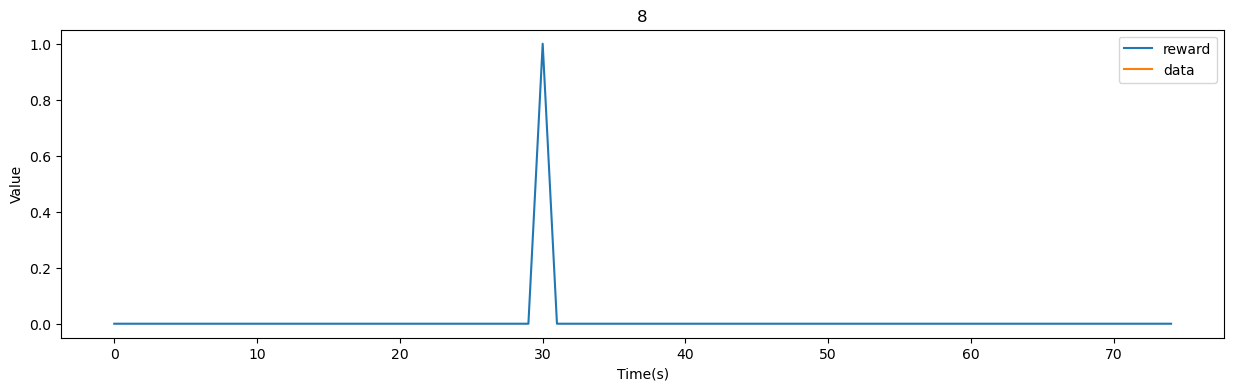

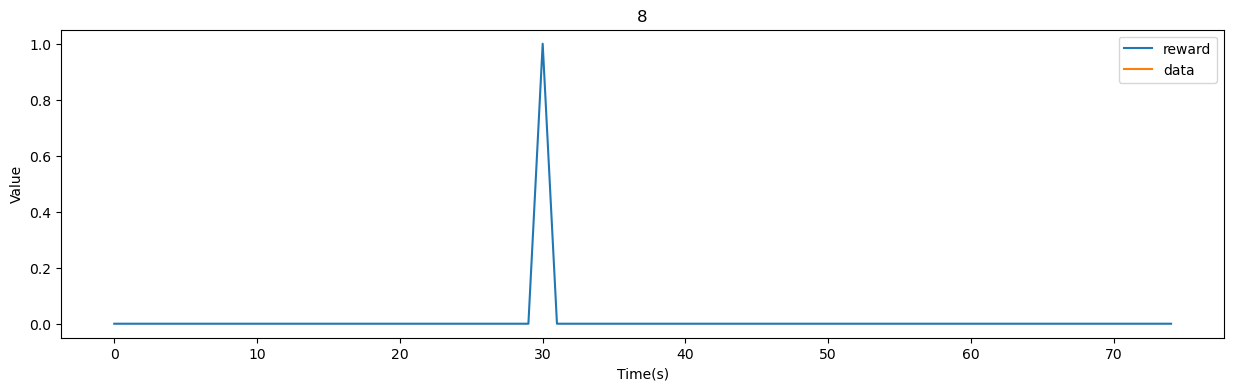

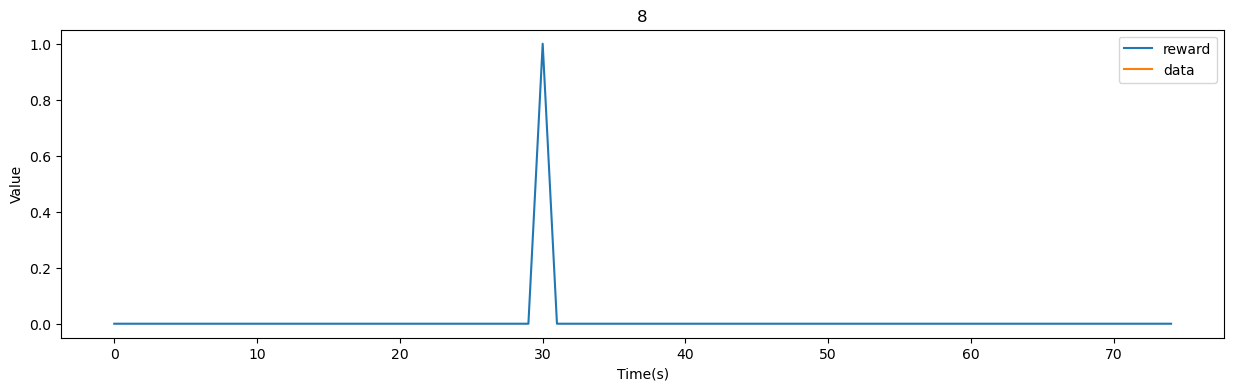

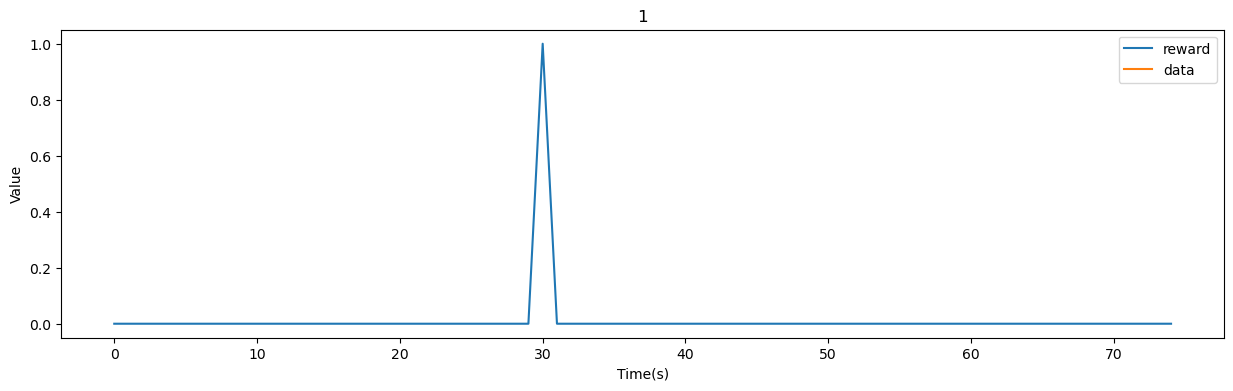

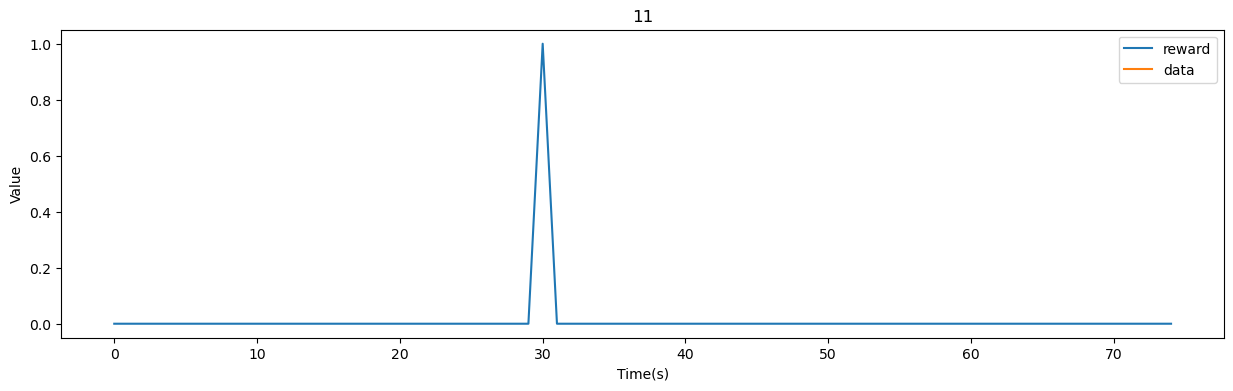

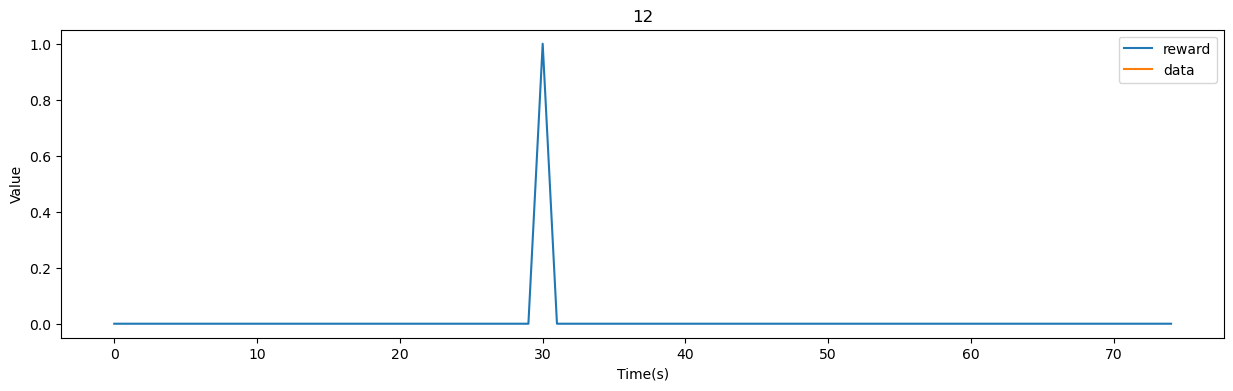

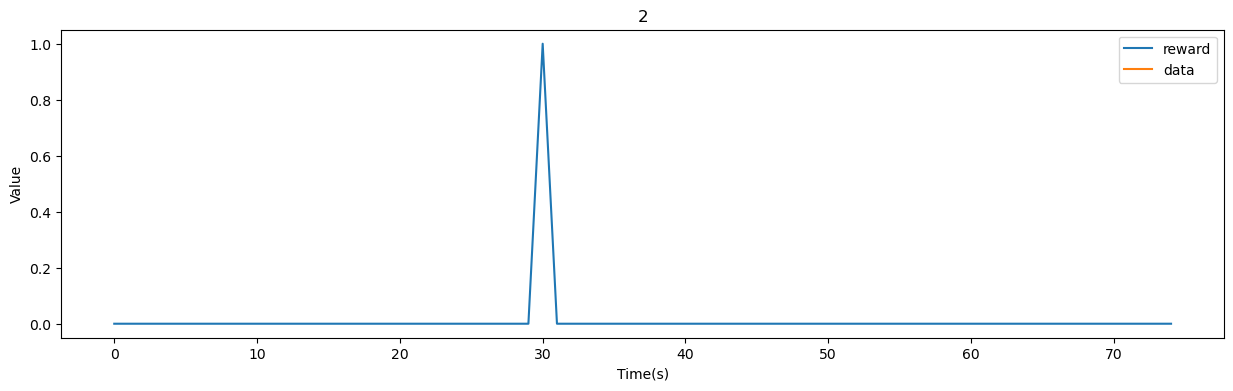

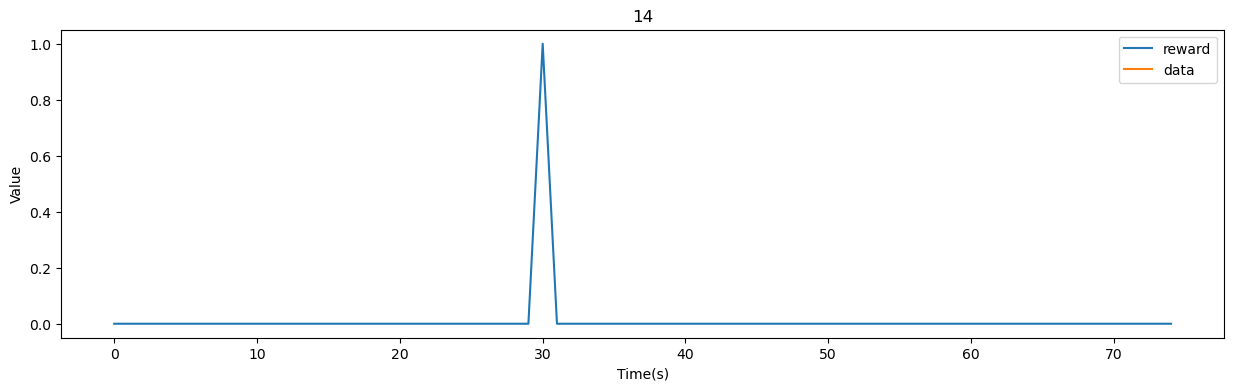

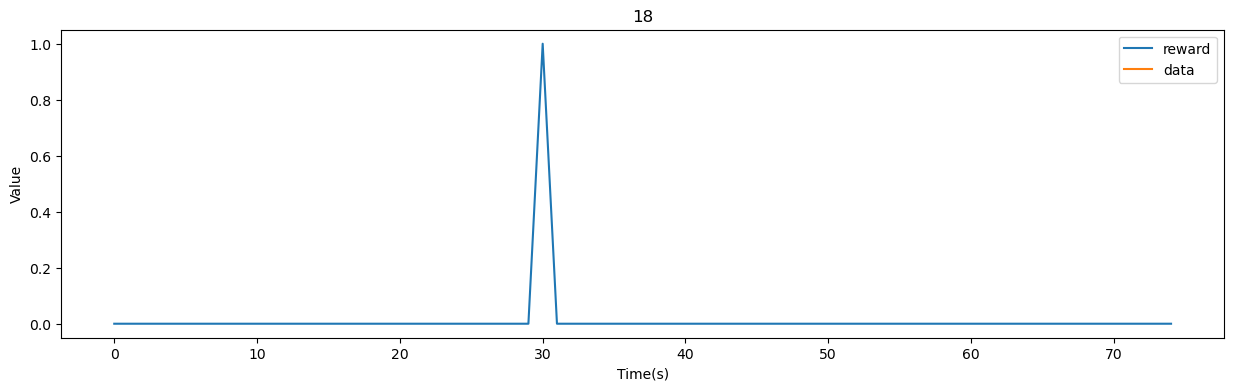

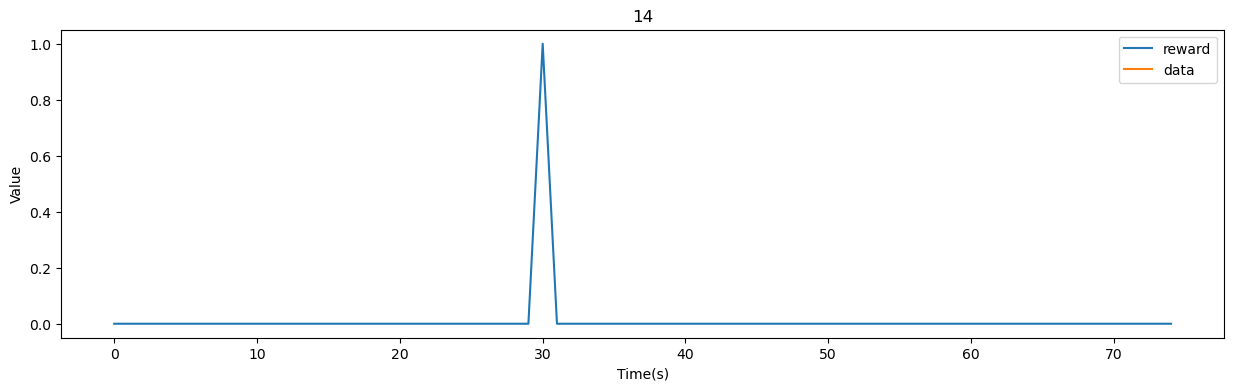

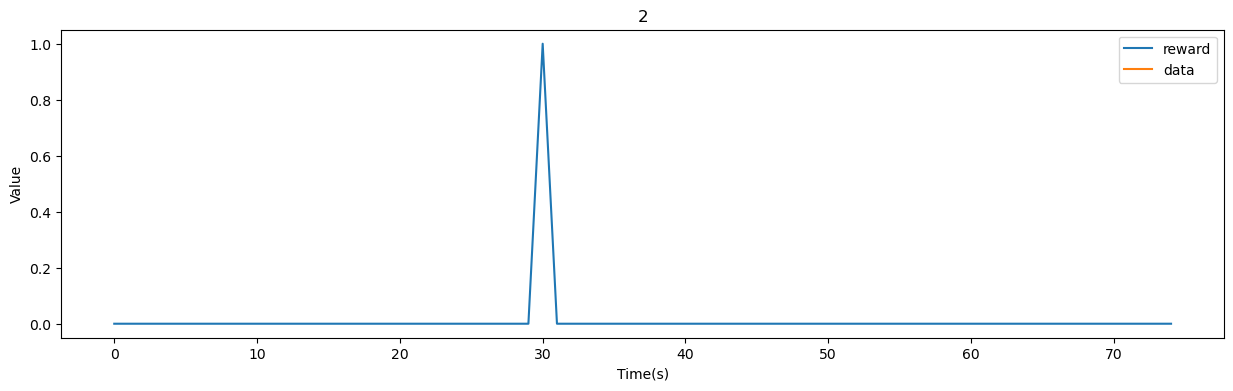

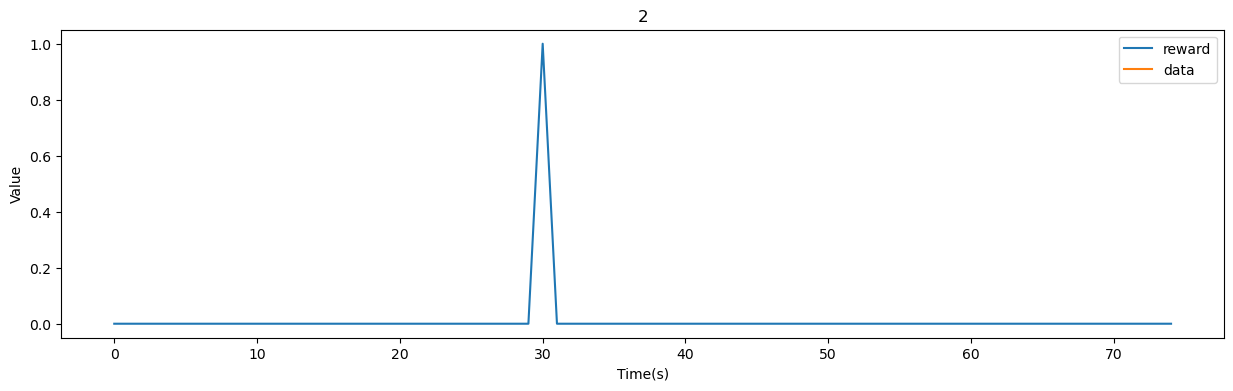

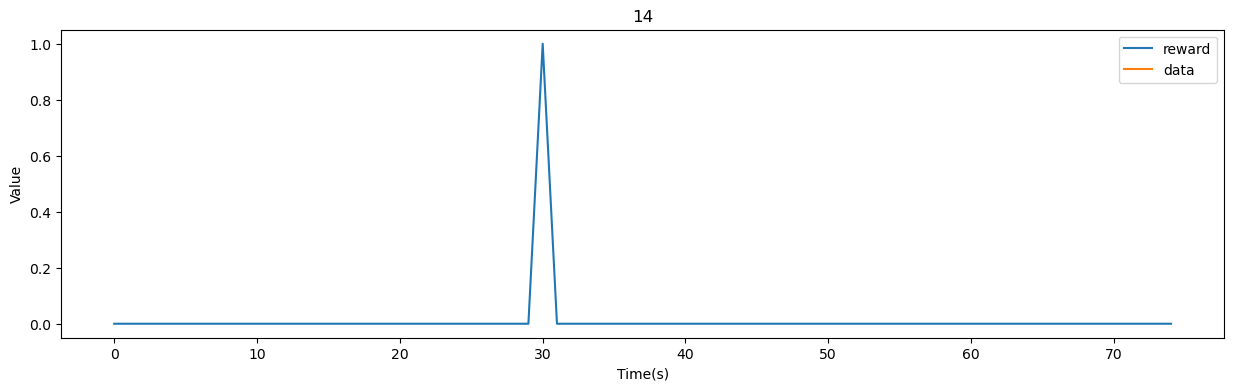

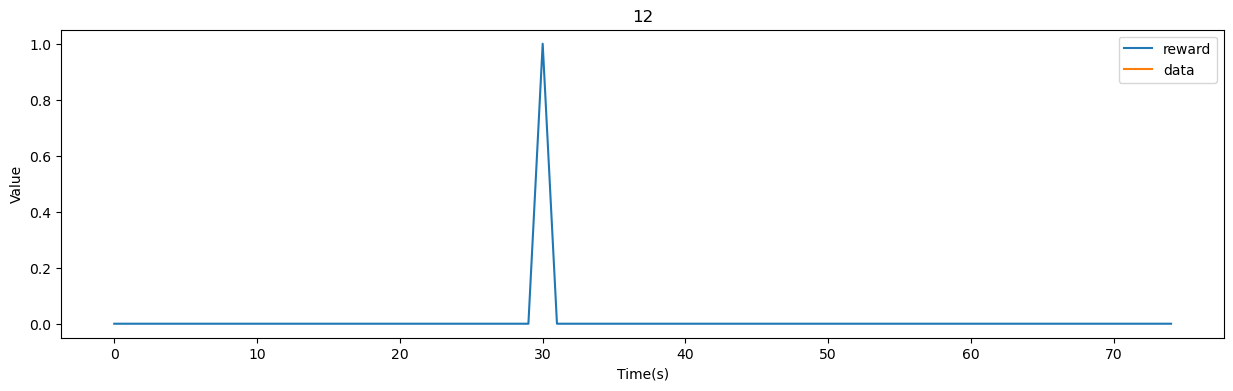

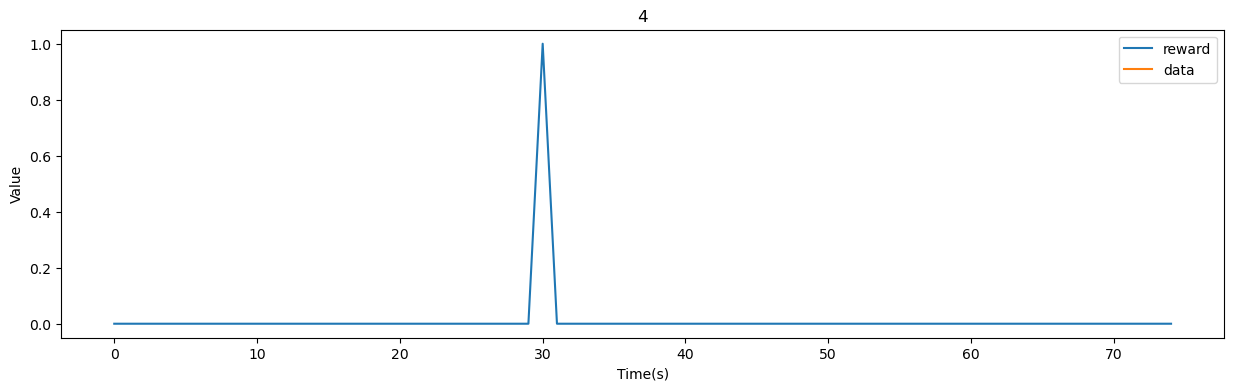

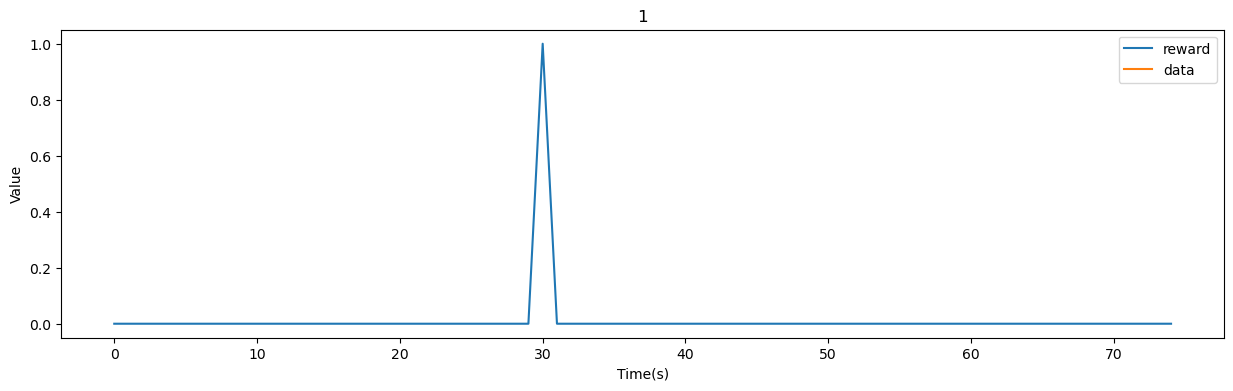

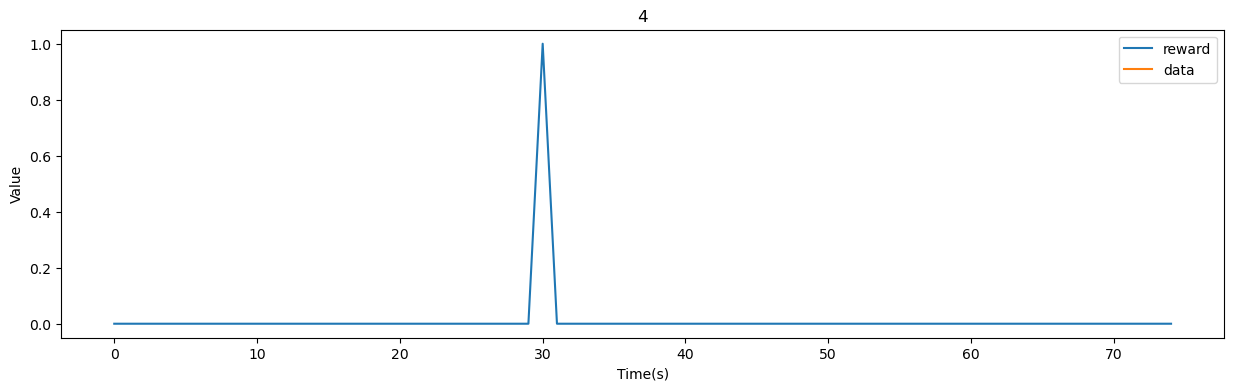

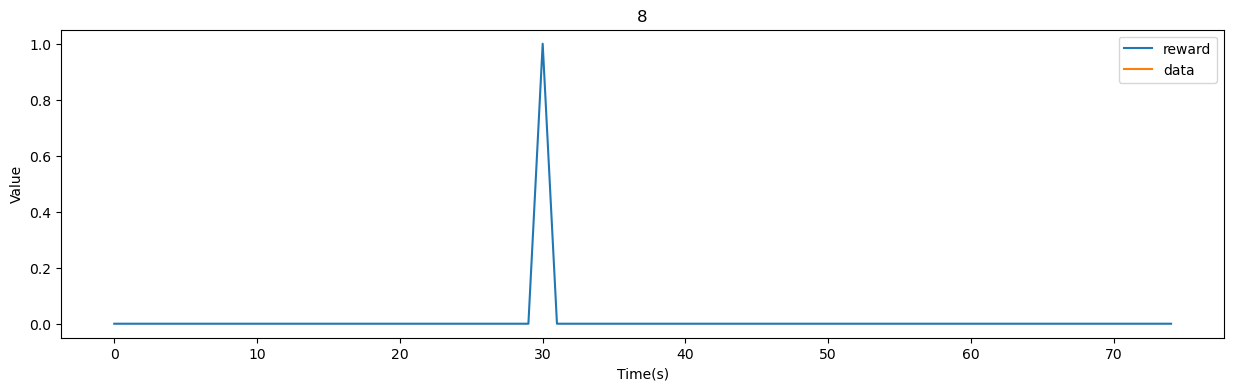

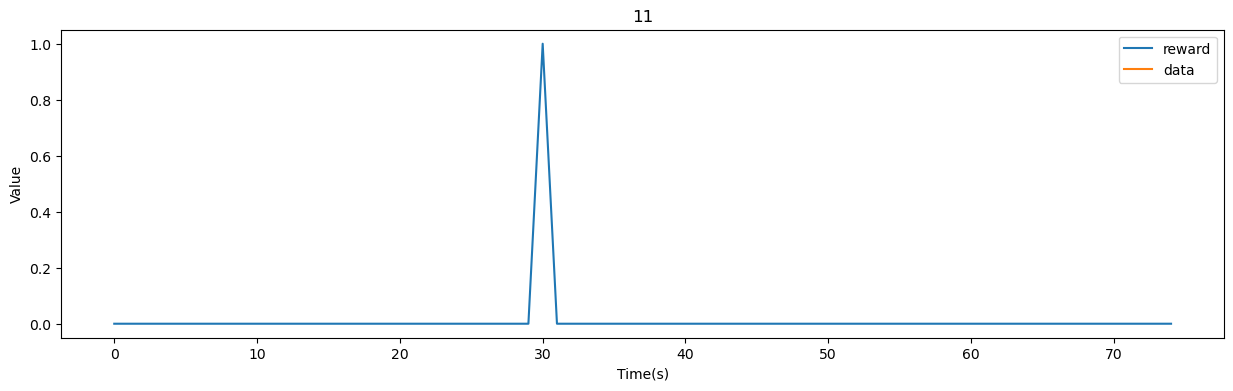

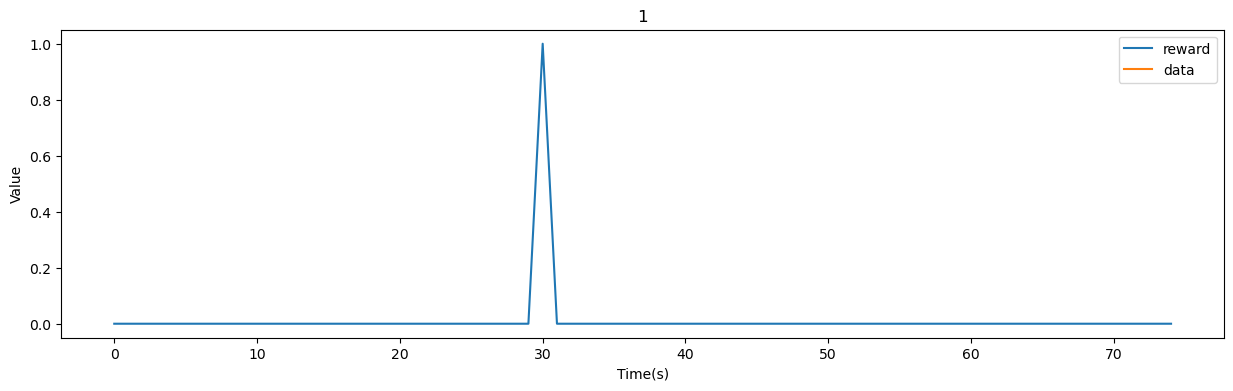

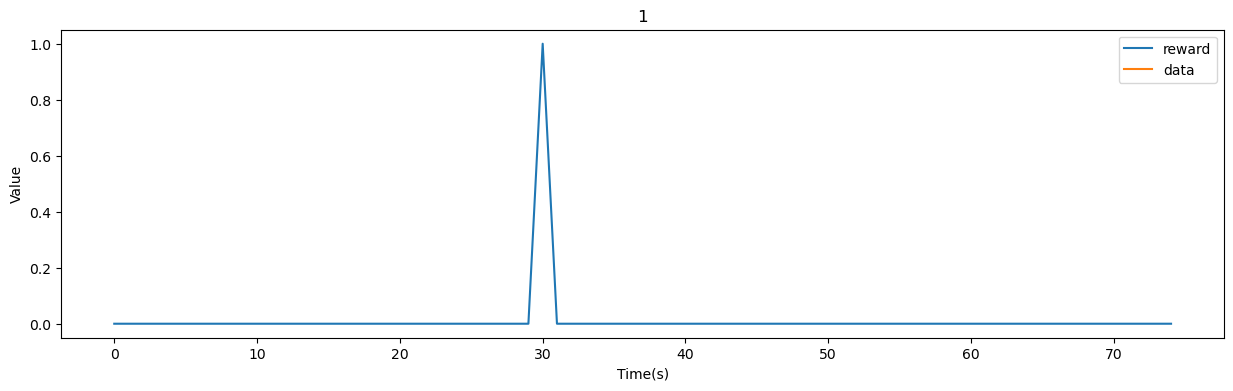

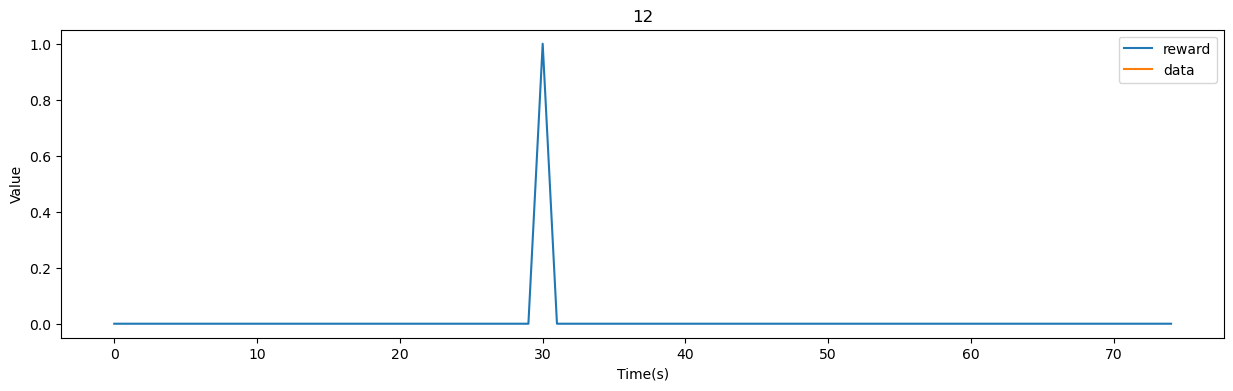

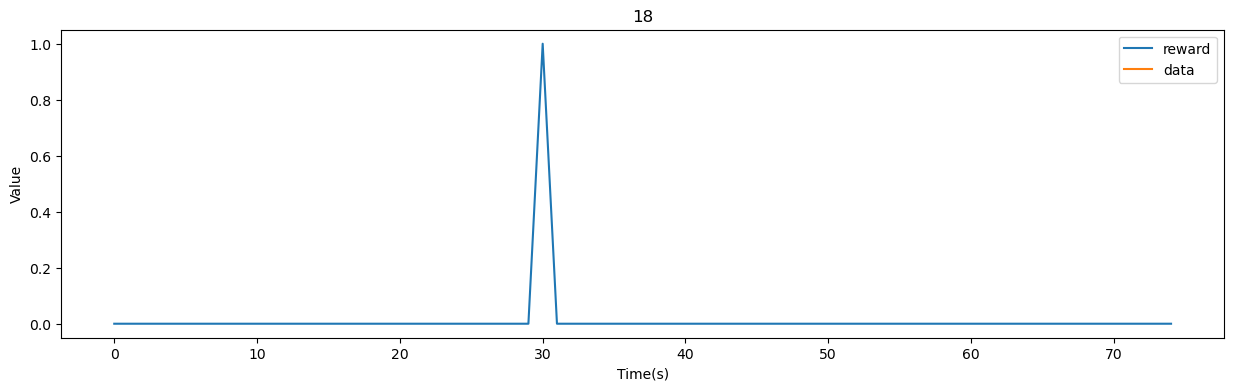

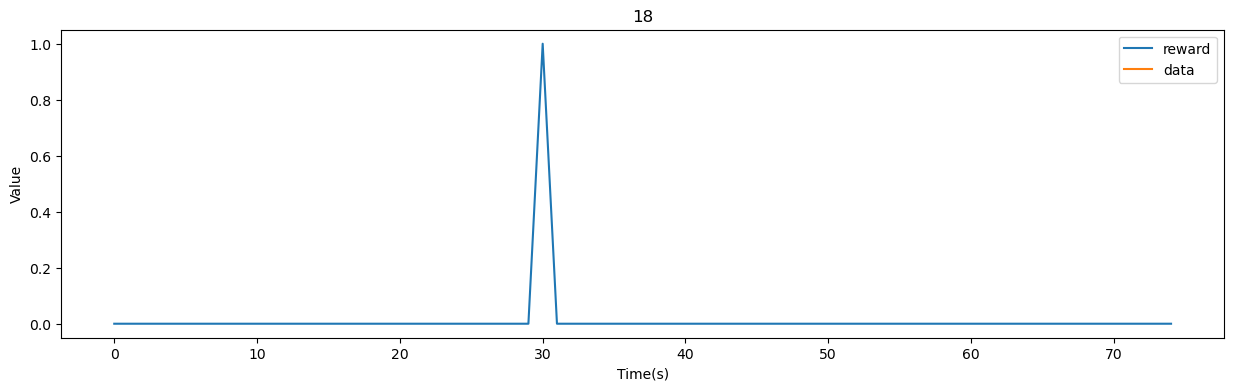

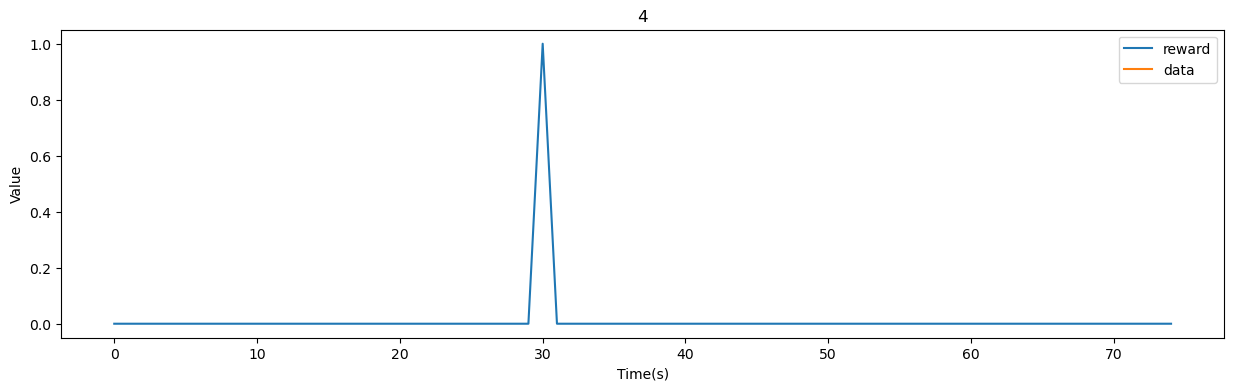

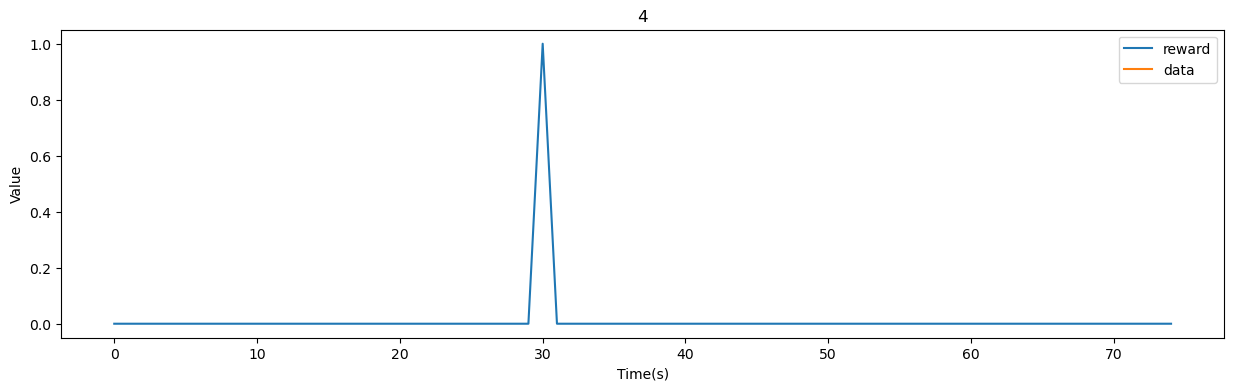

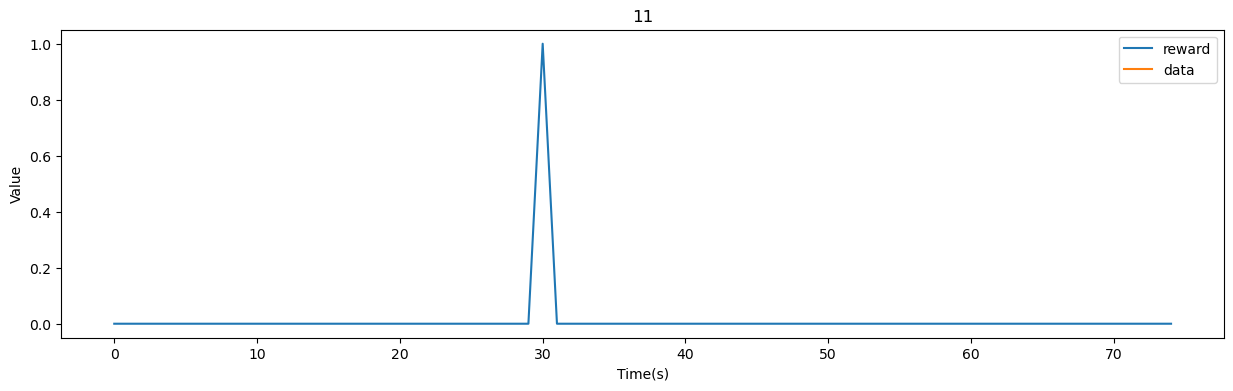

In [1236]:
time = np.arange(calcium_traces.shape[1])/30
time = np.arange(reward_binary.shape[0])
time = np.arange(75)
for i, frame in enumerate(ms_cueFrames):
    plt.figure(figsize=(15, 4))
    plt.plot(time, normalize(cue_binary[frame-30:frame+45]), label='reward')
    plt.plot(time, normalize(spikes[19,frame-30:frame+45]), label='data')
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.title(f'{trialRewards[i]}')
    plt.legend()
    plt.show()

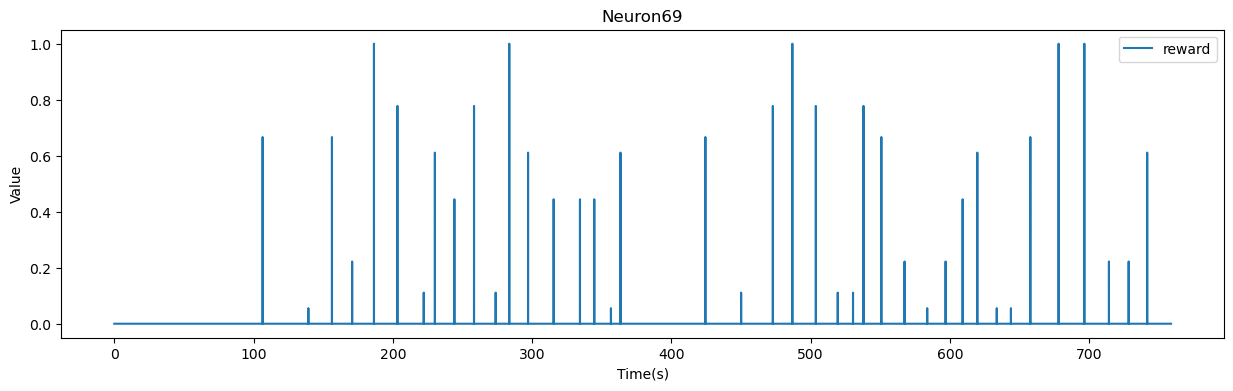

In [1237]:
time = np.arange(calcium_traces.shape[1])/30
# time = np.arange(1000)/30
plt.figure(figsize=(15, 4))
plt.plot(time, normalize(reward_binary), label='reward')
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.title(f'Neuron{neuron_idx}')
plt.legend()
plt.show()

In [1262]:
all_models[4].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20350
Model:                            GLM   Df Residuals:                    20348
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1463.7
Date:                Mon, 14 Apr 2025   Deviance:                       1791.4
Time:                        15:02:46   Pearson chi2:                 7.94e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02476
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6878      0.071    -65.668      0.000      -4.828      -4.548
x1             0.2523      0.009     28.322      0.000       0.235       0.270
==============================================================================
"""

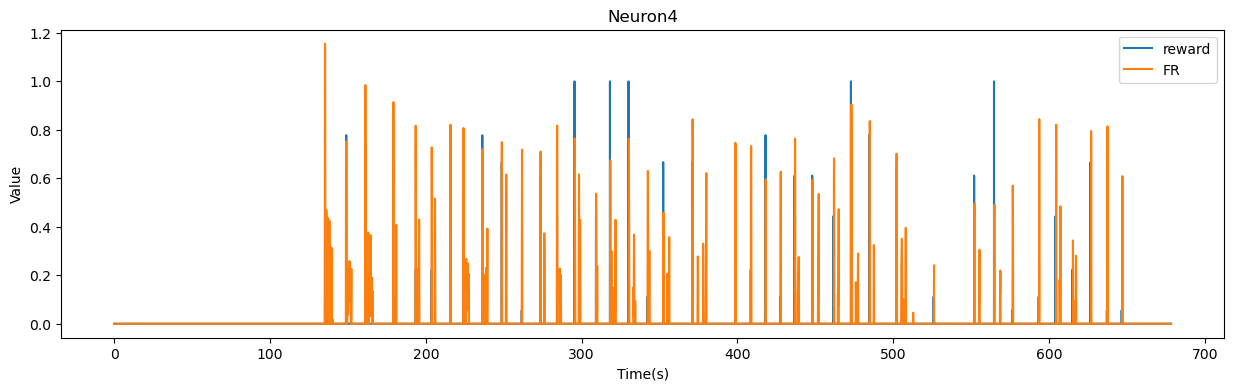

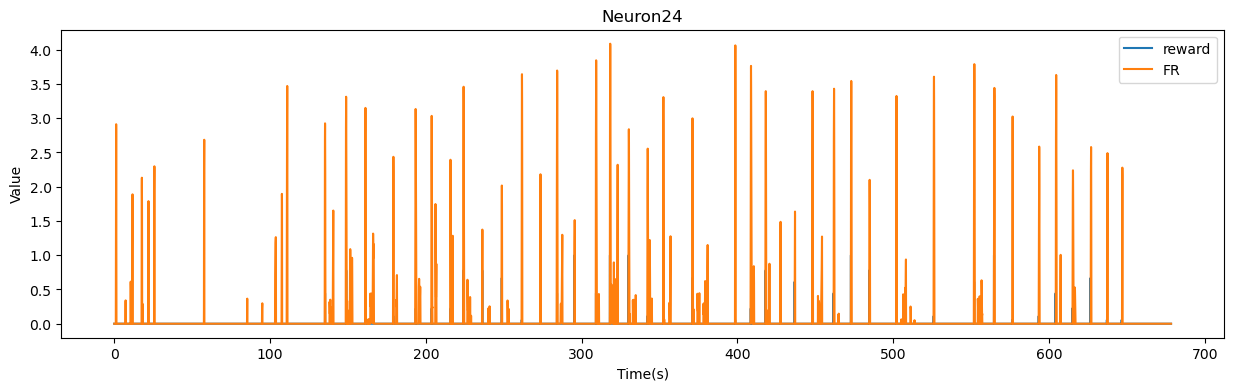

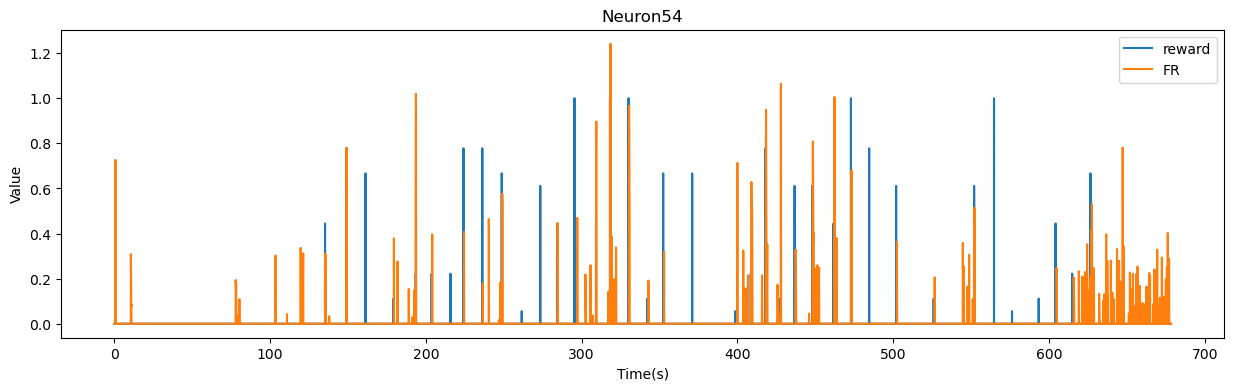

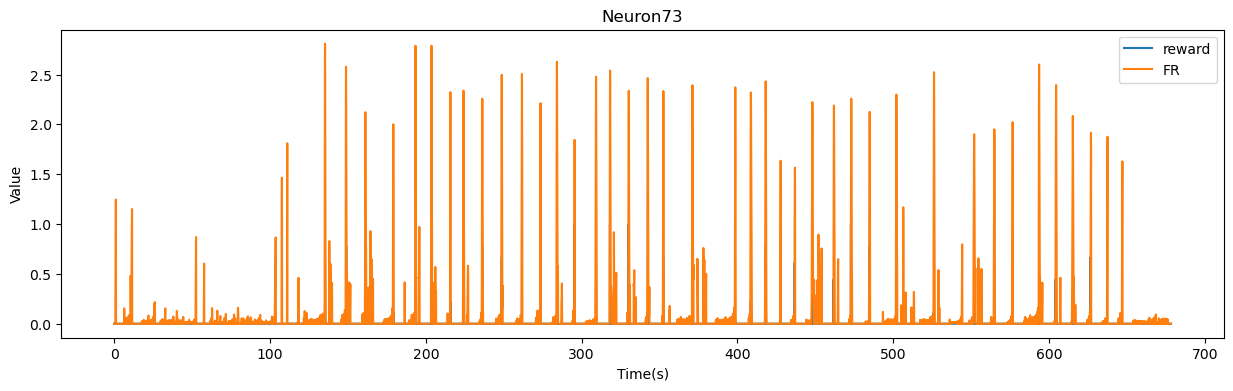

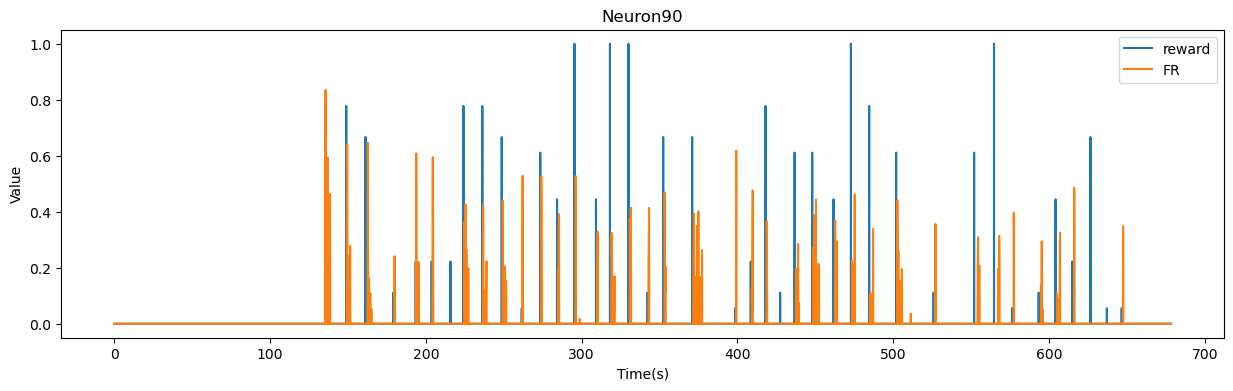

In [1257]:


all_models_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/reward_amounts/all_neuron_glm_models.pkl'
with open(all_models_path, 'rb') as f:
    all_models = pickle.load(f)
all_neuron_fde = np.load(f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/reward_amounts/all_neuron_fde.npy')
for neuron_idx in np.where(all_neuron_fde > 0.2)[0]:
    time = np.arange(calcium_traces.shape[1])/30
    # time = np.arange(1000)/30
    plt.figure(figsize=(15, 4))
    plt.plot(time, normalize(reward_binary), label='reward')
    plt.plot(time, spikes[neuron_idx,:], label='FR')
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.title(f'Neuron{neuron_idx}')
    plt.legend()
    plt.show()

In [1239]:
reward_amounts = [1,2,4,8,11,12,14,18]
population_activity = spikes.mean(axis=0)
population_mean_firing_rates_reward = np.zeros(40)
for i in range(40):
    population_mean_firing_rates_reward[i] = population_activity[ms_rewardFrames[i]+5:ms_rewardFrames[i]+45].mean()

In [1240]:
score_total = {}
for reward_amount in reward_amounts:
    score = 0
    # mean_firing_rate_across_trial = population_mean_firing_rates_reward[np.where(trialRewards==reward_amount)[0]].mean()
    zscored_meanFR = z_score(population_mean_firing_rates_reward, axis=0)
    # for reward_amount_compared in reward_amounts:
        # mean_firing_rate_across_trial_compared = population_mean_firing_rates_reward[np.where(trialRewards==reward_amount_compared)[0]].mean()
        # if (reward_amount_compared-reward_amount)*(mean_firing_rate_across_trial_compared-mean_firing_rate_across_trial) > 0:
        #     score += 1
    greater_reward_trials = np.where(trialRewards>reward_amount)[0]
    less_reward_trials = np.where(trialRewards<reward_amount)[0]
    if greater_reward_trials.size > 0:
        for t in greater_reward_trials:
            if zscored_meanFR[t] > 0:
                score +=1
    if less_reward_trials.size > 0:
        for t in less_reward_trials:
            if zscored_meanFR[t] < 0:
                score += 1
    score_total[reward_amount] = score
    folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/Dabney_scores/{mouse}_{date}/'
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    with open(f'/Users/fgs/HMLworkplace/Arena_analysis/Results_temp/Dabney_scores/{mouse}_{date}/population.pkl', 'wb') as f:
        pickle.dump(score_total, f)